In [65]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [25]:
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt

In [203]:
import torch
import torch.nn as nn
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import LiteralListener, LiteralSpeaker, CaptionEncoder, CaptionGenerator, PytorchModel, ColorEncoder
from experiment import FeatureHandler
import scipy.stats as stats

In [548]:
from evaluation import score_model, Score

In [563]:
import evaluation
importlib.reload(evaluation)
import evaluation
from evaluation import score_model, Score

In [555]:
Score.CONDITION

<Score.CONDITION: 2>

In [100]:
import importlib
import experiment
importlib.reload(experiment)

<module 'experiment' from '../experiment.py'>

In [68]:
# Misc. setup
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth_10fold.csv", "../data/entries/dev_corpus_synth_10fold.pkl")

In [179]:
# Imaginative Listener

# Initializing featurizers
print("Initializing featurizers")
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"

color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

# Now we have a different target function, because we want to predict the target color directly
def target_color_target(data_entry):
    return np.array(data_entry.colors[0].rgb_norm)

feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi, target_fn=target_color_target,
                                randomized_colors=False)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()



Initializing featurizers
Obtaining training features


In [206]:
# def score_model(test_data, scores, regressor=stats.pearsonr):
#     """
#     Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
#     between the scores of the individual games and the scores from the model
#     """
#     relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq"]

#     eval_df = test_data.data[relevant_columns].copy()
#     eval_df["model_scores"] = scores # why we need scores to be in same order as rows

#     #true_scores = eval_df.groupby("gameid").numOutcome.mean()
#     true_scores = eval_df.groupby("gameid").numOutcome.mean()
#     model_scores = eval_df.groupby("gameid").model_scores.mean()

#     result = regressor(true_scores, model_scores)
#     print(result)
#     return result, true_scores, model_scores

In [ ]:
print("Initializing model")
# model parameters
# embed_dim = 100; hidden_dim = 100; color_dim= 54; # hard coded for example - 54 comes from color fourier phi




In [ ]:
# Model 1: simplest version of the model - generate target color from just description
# (output to rgb)

In [261]:
class ColorGenerator(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size):
        super(ColorGenerator, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        
    def forward(self, caption):
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)
        output = self.linear1(output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output
        
        

In [452]:
# Model 2: second simplest version of the model - generate target color from description AND distractors
# (output to rgb)
class ColorGeneratorWithDistractors(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim, weight_matrix = None):
        super(ColorGeneratorWithDistractors, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        if weight_matrix is not None:
            self.embed.load_state_dict({'weight': weight_matrix})
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # RNN for colors
        self.color_rnn = nn.RNN(color_in_dim, color_hidden_dim, bidirectional=True, batch_first=True)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim + 2*color_hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        self.color_hidden_dim = color_hidden_dim
        
    def forward(self, caption, colors):
        # get caption encodings
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        
        # get color encodings
        color_encodings, _ = self.color_rnn(colors)
        # concatenate rnn outputs bc we have bidirectional rnn
        color_encodings = torch.cat((color_encodings[:, -1, : self.color_hidden_dim],
                                     color_encodings[:, 0, self.color_hidden_dim :]), 1)
        
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)

        # combine colors and caption
        combined_output = torch.cat((output, color_encodings), 1)
        output = self.linear1(combined_output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output
        
        

In [491]:
# Model 3: third simplest version of the model - generate target color from description AND distractors
# (but just use fully connected layers rather than an RNN to encode the colors
class ColorGeneratorWithDistractorsLinear(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim, weight_matrix=None):
        super(ColorGeneratorWithDistractorsLinear, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        if weight_matrix is not None:
            self.embed.load_state_dict({'weight': weight_matrix})
            
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # Linear layers for colors
        #self.color_rnn = nn.RNN(color_in_dim, color_hidden_dim, bidirectional=True, batch_first=True)
        self.color_encode = nn.Linear(2*color_in_dim, color_hidden_dim)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim + color_hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        self.color_hidden_dim = color_hidden_dim
        
    def forward(self, caption, colors):
        # get caption encodings
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        
        # get color encodings
        colors = colors.reshape(1, 1, -1)
        color_encodings = nn.functional.relu(self.color_encode(colors))
        color_encodings = color_encodings.squeeze(0)
        
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)

        # combine colors and caption
        combined_output = torch.cat((output, color_encodings), 1)
        output = self.linear1(combined_output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output
        
        

In [423]:
class ImaginativeListener(PytorchModel):
    def __init__(self, model, use_color=True, **kwargs):
        super(ImaginativeListener, self).__init__(model, **kwargs)
        self.use_color = use_color
        
    def train_iter(self, caption_tensor, color_tensor, target_tensor, optimizer, criterion):
        optimizer.zero_grad()
        loss = 0
        
        # not using colors at the moment
        if self.use_color:
            color_tensor = color_tensor[:, 1:3, :] # don't include the target at index 0
            model_output = self.model(caption_tensor, color_tensor)
        else:
            model_output = self.model(caption_tensor)
            
        if isinstance(criterion, nn.MSELoss):
            loss += criterion(model_output, target_tensor.type(torch.FloatTensor))
        else:
            model_output = model_output.type(torch.DoubleTensor)
            label = torch.tensor(1, dtype=torch.double)
            loss += criterion(model_output, target_tensor.detach(), label)
        loss.backward()
        optimizer.step()
        
        return loss
        
    def predict(self, X):
        model_outputs = np.empty([len(X), 3])
        self.model.eval()
        with torch.no_grad():
            for i, feature in enumerate(X):
                caption, colors = feature
                caption_tensor = torch.tensor([caption], dtype=torch.long)
                color_tensor = torch.tensor([colors], dtype=torch.float)
                if self.use_color:
                    color_tensor = color_tensor[:, 1:3, :] # don't include the target
                    model_output = self.model(caption_tensor, color_tensor)
                else:
                    model_output = self.model(caption_tensor)
                    
                model_output_np = model_output.view(-1).numpy()
                model_outputs[i] = model_output_np
        return np.array(model_outputs)

In [262]:
model = ImaginativeListener(ColorGenerator, criterion=torch.nn.CosineEmbeddingLoss, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)
model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size)

In [263]:
train = False
model_file = "../model/imaginative_listener_5epoch.params"


if train:
    print("Training model and saving to {}:".format(model_file))
    model.fit(train_features, train_targets)
    model.save_model(model_file)
else:
    print("Loading pretrained model")
    model.load_model(model_file)

Loading pretrained model


In [264]:
assess_features = feature_handler.test_features()
assess_targets = feature_handler.test_targets()

In [265]:
assess_model_outputs = model.predict(assess_features)

In [227]:
output_to_score_cosine = lambda output, target: 2 - scipy.spatial.distance.cosine(output, target)
output_to_score_de = lambda output, target: delta_e_dist(output, target)

In [266]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]

In [267]:
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(-0.8525642790066323, 3.031128542741804e-147)


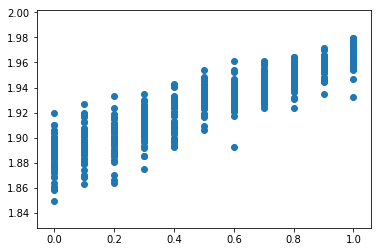

In [212]:
plt.scatter(true_scores_grouped, model_scores_grouped)

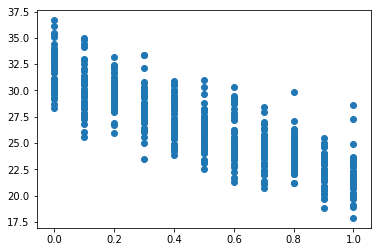

In [268]:
plt.scatter(true_scores_grouped, model_scores_grouped)

In [223]:
def delta_e_dist(color1, color2):
    """color1 and color2 are in rgb space"""
    # do some nice integer conversions
    color1 = np.round(255*color1)
    color2 = np.round(255*color2)
    # convert colors to lab
    color1_lab = color.rgb2lab(np.array([[color1]], dtype=np.uint8)).flatten()
    color2_lab = color.rgb2lab(np.array([[color2]], dtype=np.uint8)).flatten()
    
    # compute Delta E CIEDE 2000 distance
    return color.deltaE_ciede2000(color1_lab, color2_lab)

round 1


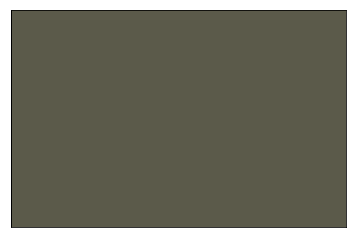

round 2


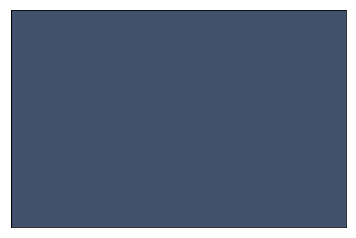

round 3


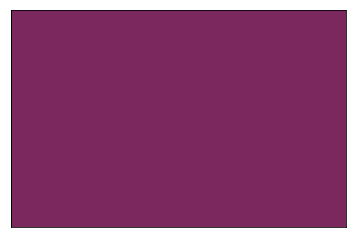

round 4


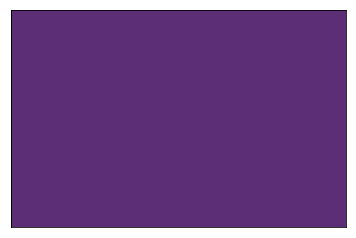

round 5


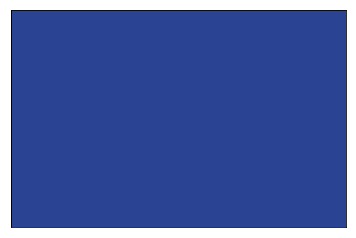

round 6


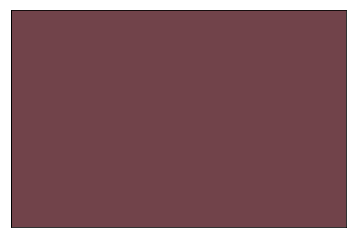

round 7


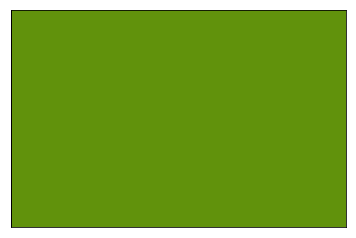

round 8


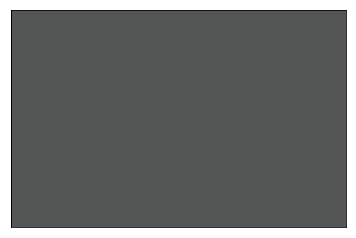

round 9


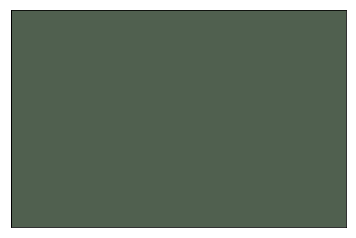

round 10


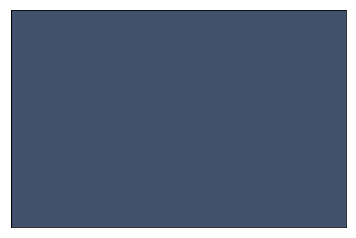

round 11


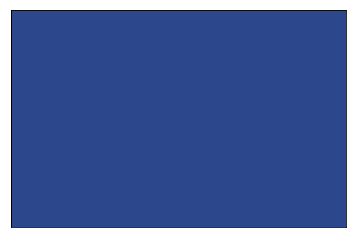

round 12


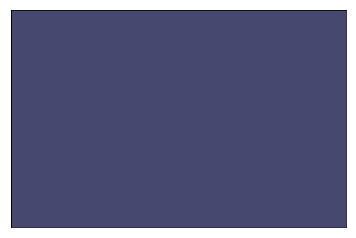

round 13


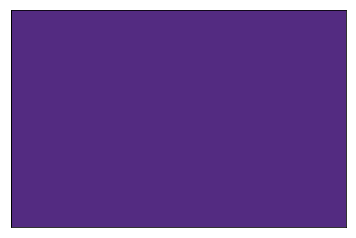

round 14


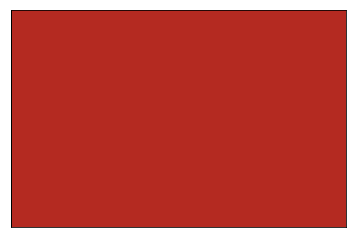

round 15


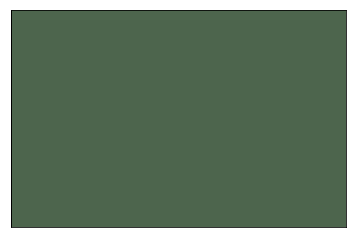

round 16


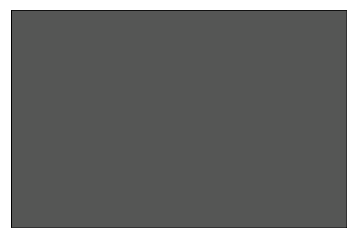

round 17


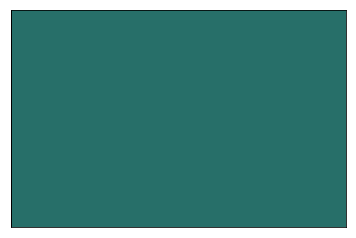

round 18


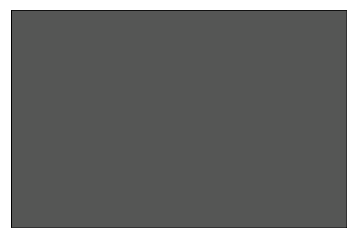

round 19


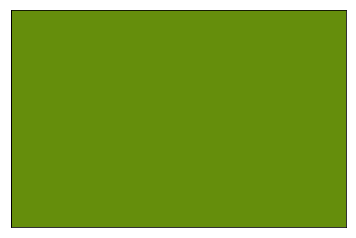

round 20


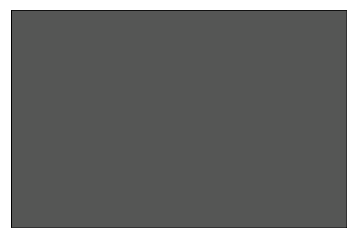

round 21


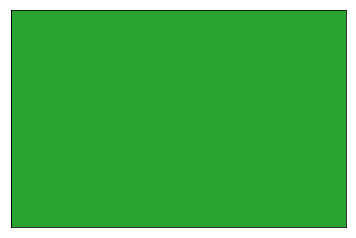

round 22


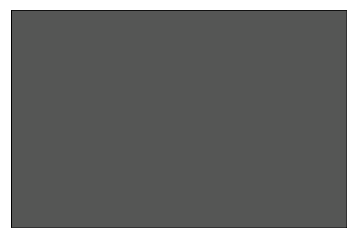

round 23


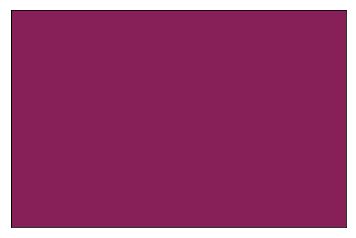

round 24


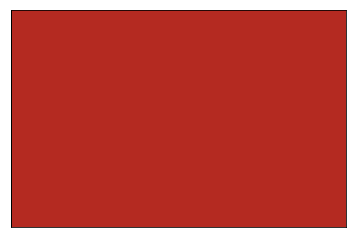

round 25


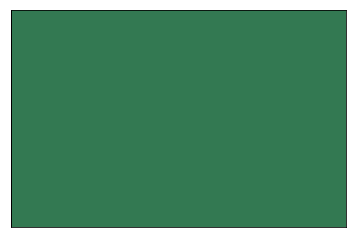

round 26


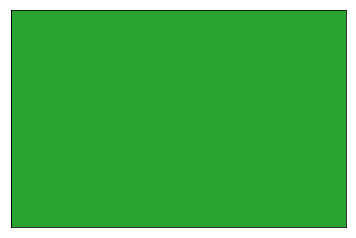

round 27


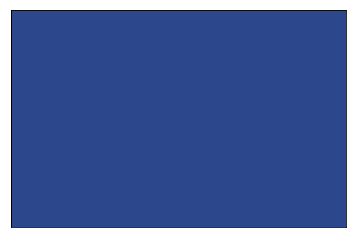

round 28


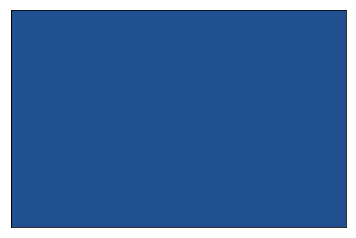

round 29


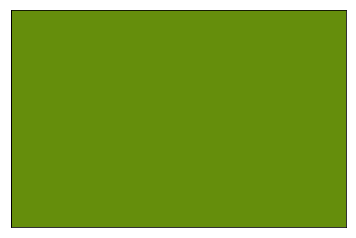

round 30


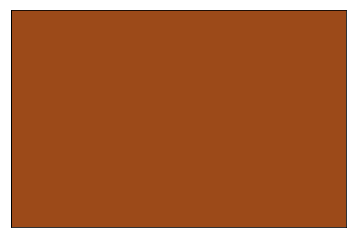

round 31


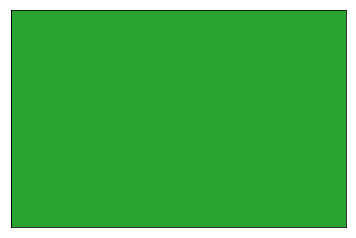

round 32


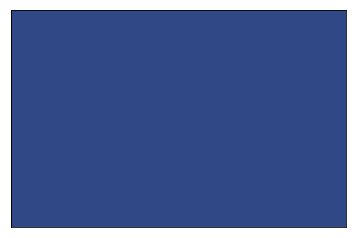

round 33


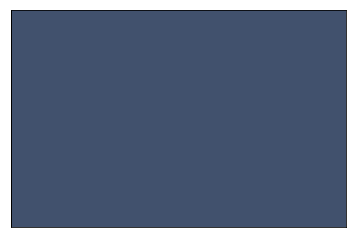

round 34


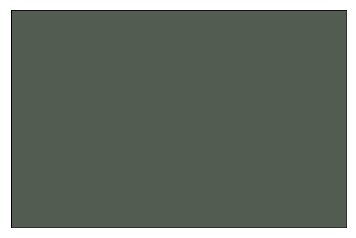

round 35


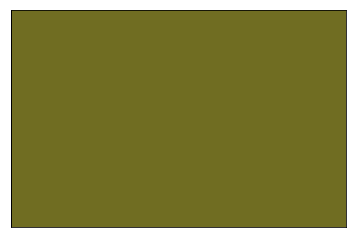

round 36


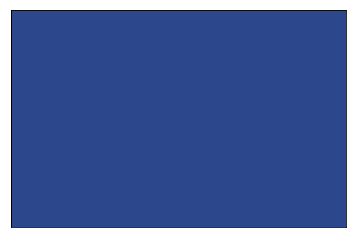

round 37


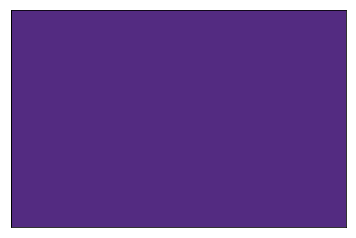

round 38


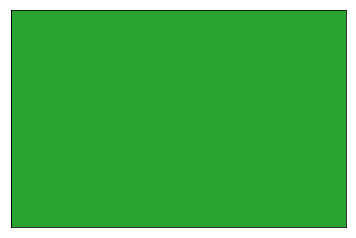

round 39


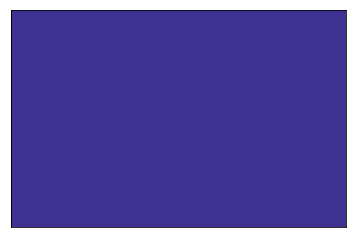

round 40


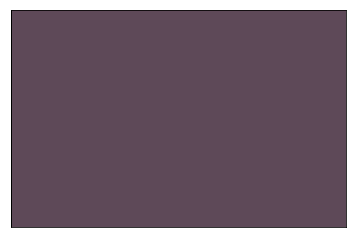

round 41


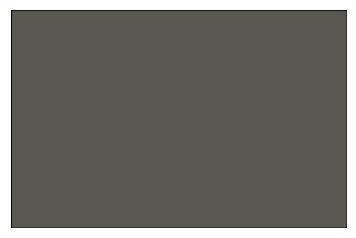

round 42


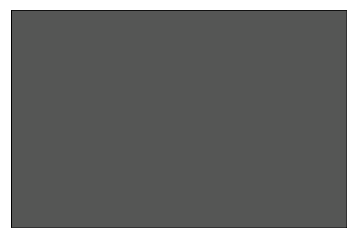

round 43


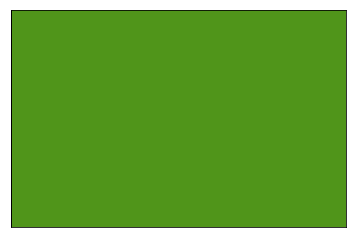

round 44


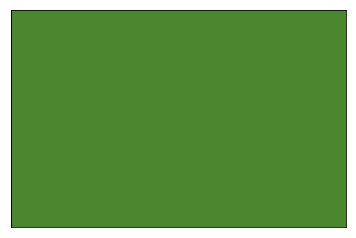

round 45


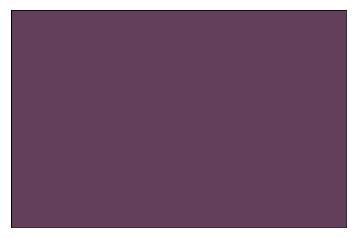

round 46


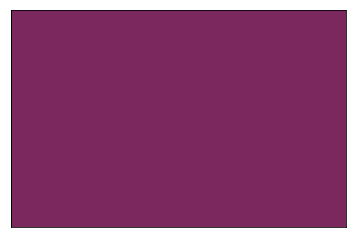

round 47


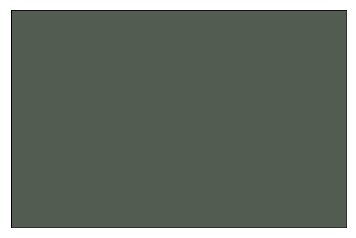

round 48


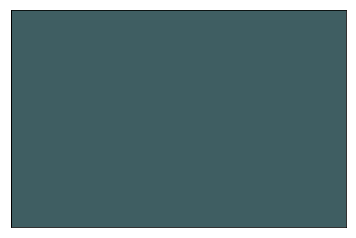

round 49


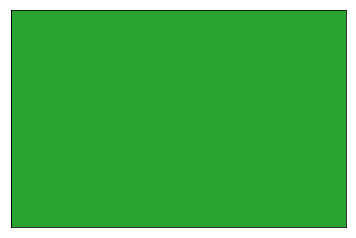

round 50


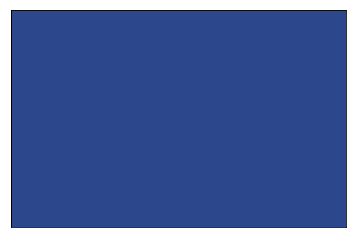

In [242]:
for i in range(50):
    train_data.display_target(assess_model_outputs[i], "round %d"%(i+1))

0) Game: synth-0 Round: 1
concrete


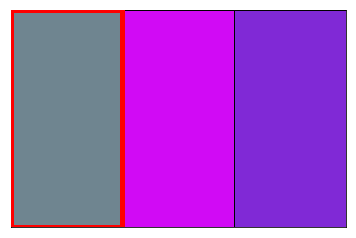

1) Game: synth-0 Round: 2
the concrete mixed with sky


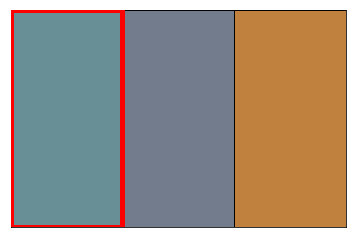

2) Game: synth-0 Round: 3
pink


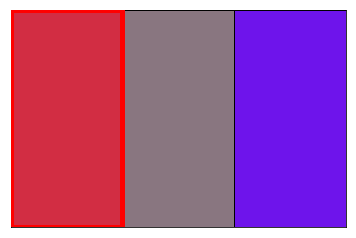

3) Game: synth-0 Round: 4
the dullest purple


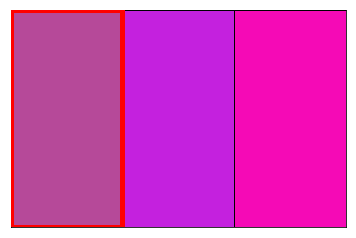

4) Game: synth-0 Round: 5
the brighter blue


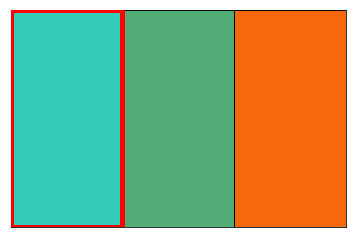

5) Game: synth-0 Round: 6
brown/orange


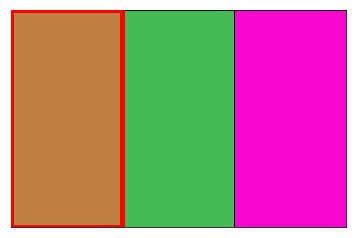

6) Game: synth-0 Round: 7
the yellowest one


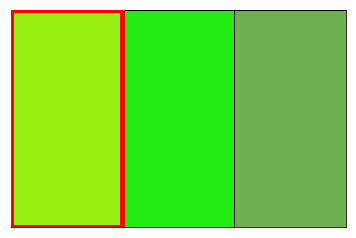

7) Game: synth-0 Round: 8
the greyest one


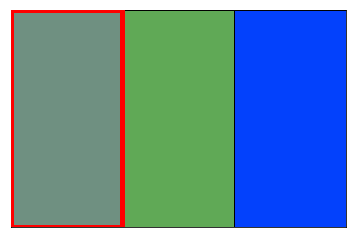

8) Game: synth-0 Round: 9
the brighter lavender


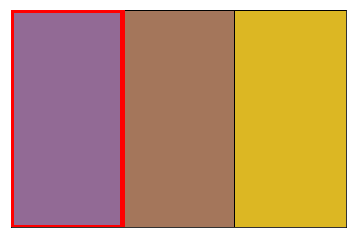

9) Game: synth-0 Round: 10
the most sky of the colors


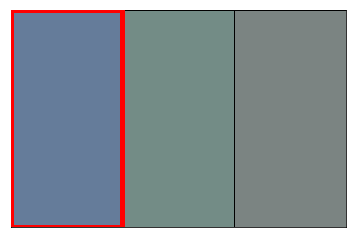

10) Game: synth-0 Round: 11
blue


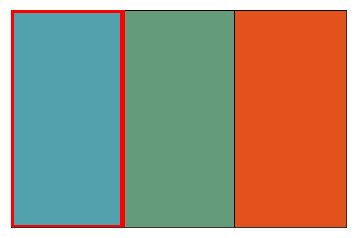

11) Game: synth-0 Round: 12
the purplish blue


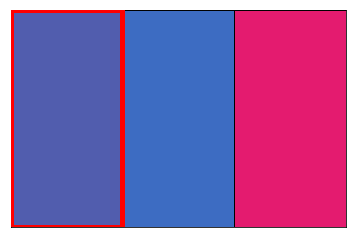

12) Game: synth-0 Round: 13
the most intense one


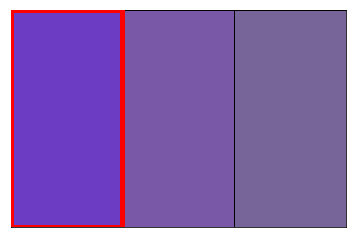

13) Game: synth-0 Round: 14
red


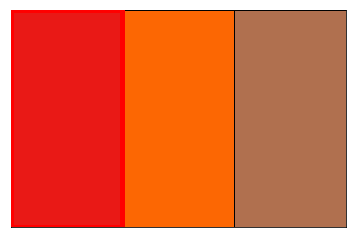

14) Game: synth-0 Round: 15
the more grey green


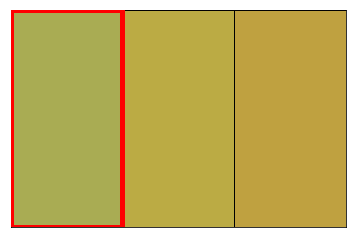

15) Game: synth-0 Round: 16
the greyish blue


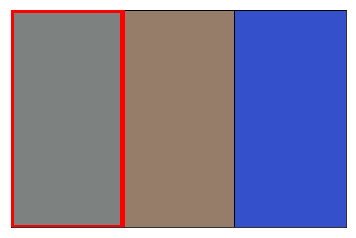

16) Game: synth-0 Round: 17
bright blue green ~ the lighter one


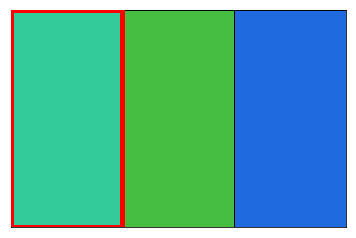

17) Game: synth-0 Round: 18
lavender


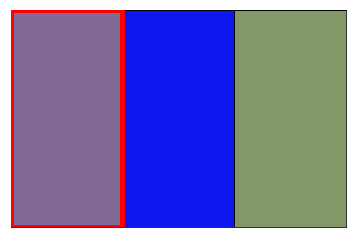

18) Game: synth-0 Round: 19
yellow


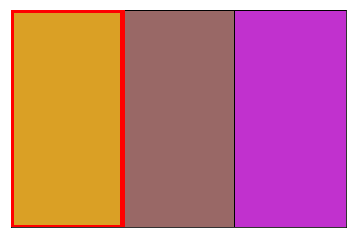

19) Game: synth-0 Round: 20
grey


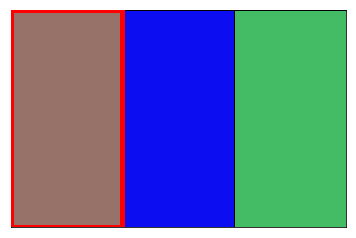

20) Game: synth-0 Round: 21
green


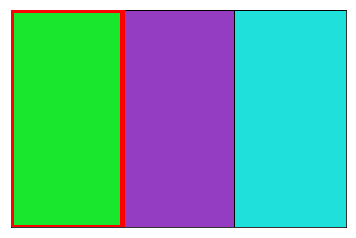

21) Game: synth-0 Round: 22
the bluer grey


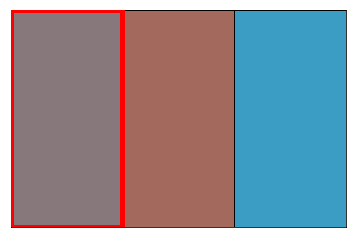

22) Game: synth-0 Round: 23
the pinker pink


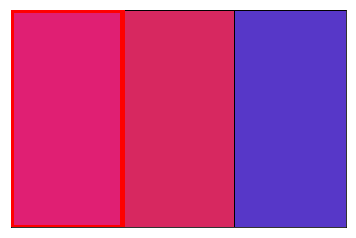

23) Game: synth-0 Round: 24
red


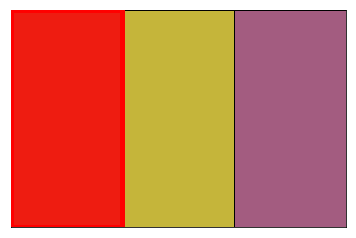

24) Game: synth-0 Round: 25
the duller aqua


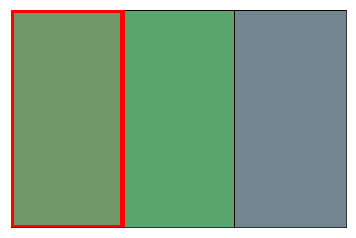

25) Game: synth-0 Round: 26
green


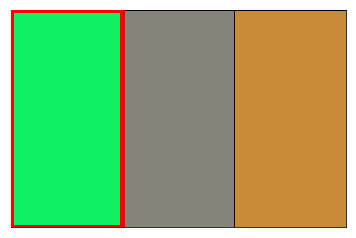

26) Game: synth-0 Round: 27
blue


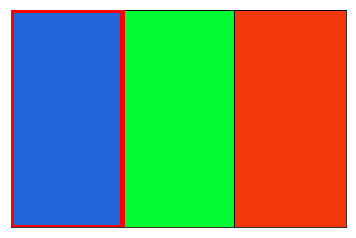

27) Game: synth-0 Round: 28
the most intense blue


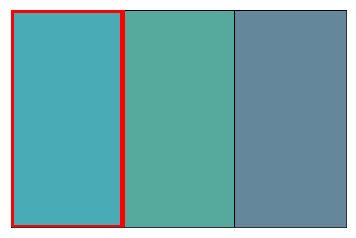

28) Game: synth-0 Round: 29
yellow


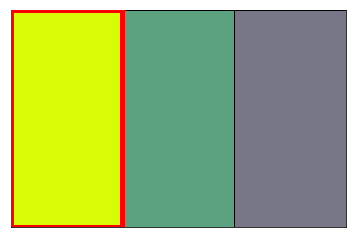

29) Game: synth-0 Round: 30
orange


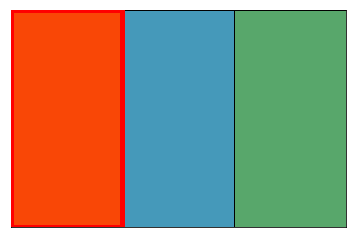

30) Game: synth-0 Round: 31
green


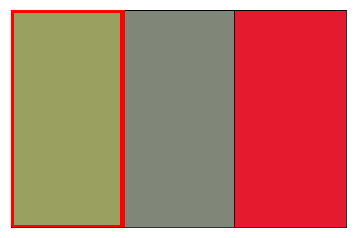

31) Game: synth-0 Round: 32
the lighter blue


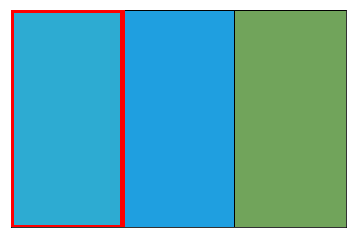

32) Game: synth-0 Round: 33
the dull slightly bluish lavender


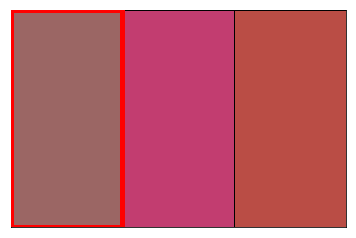

33) Game: synth-0 Round: 34
the brightest one


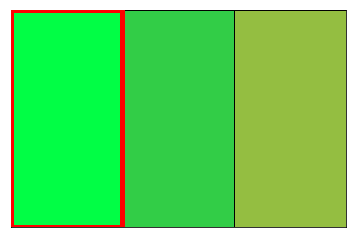

34) Game: synth-0 Round: 35
the one that looks more yellow, but not greyed out


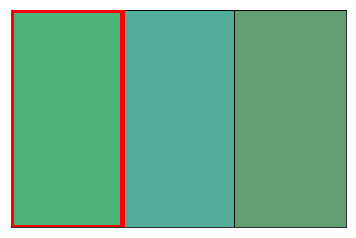

35) Game: synth-0 Round: 36
blue


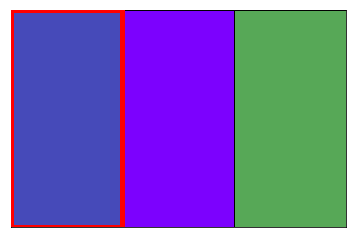

36) Game: synth-0 Round: 37
the most intense one


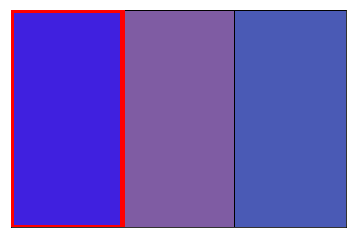

37) Game: synth-0 Round: 38
green


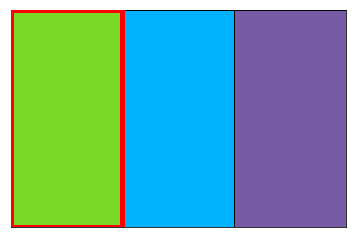

38) Game: synth-0 Round: 39
Royal of the two ~ non the confederate uniform ~ oh darker! more like 'rain'


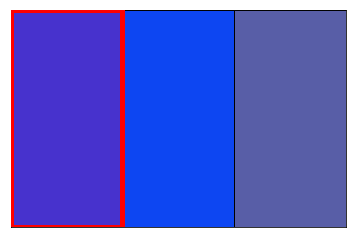

39) Game: synth-0 Round: 40
lavender ~ the duller one


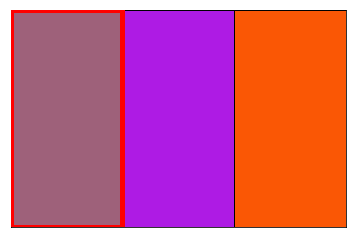

40) Game: synth-0 Round: 41
gray


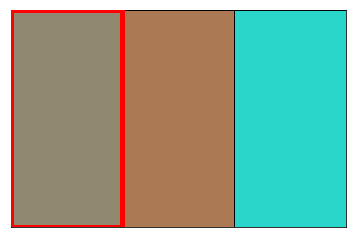

41) Game: synth-0 Round: 42
dull lavender


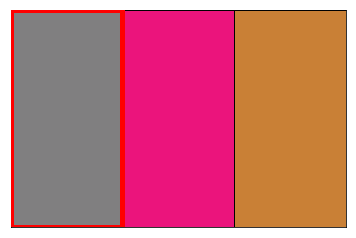

42) Game: synth-0 Round: 43
the yellower green


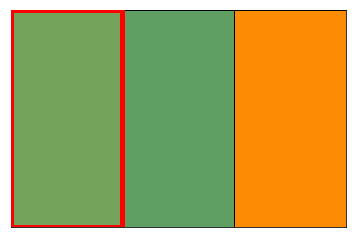

43) Game: synth-0 Round: 44
the most bright and neon looking


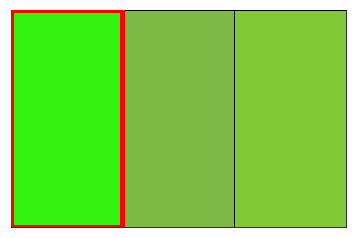

44) Game: synth-0 Round: 45
the dull lavender that is more purplish


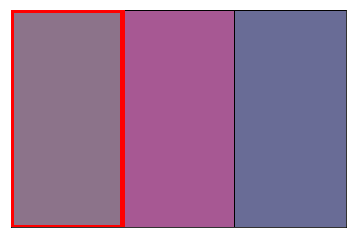

45) Game: synth-0 Round: 46
pink


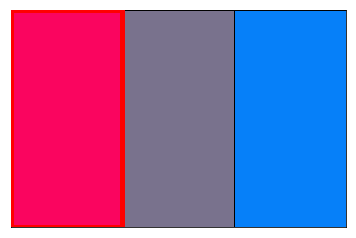

46) Game: synth-0 Round: 47
the brightest one


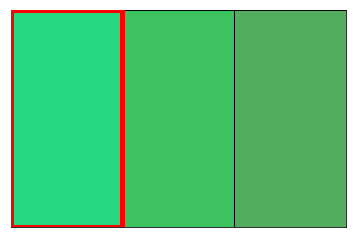

47) Game: synth-0 Round: 48
Concrete ... not with any sky or '....rain'


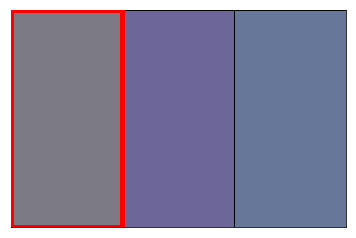

48) Game: synth-0 Round: 49
green


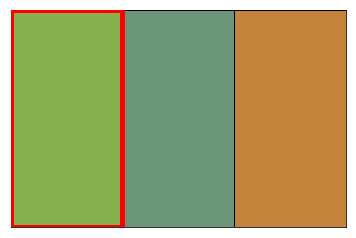

49) Game: synth-0 Round: 50
blue


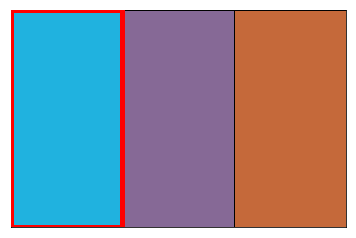

In [238]:
dev_data_synth.display_game_for_gameid("synth-0")

In [248]:
# just for evaluating :) 
def all_color_target(data_entry):
    color_array, _ = color_phi.to_color_lists(data_entry.colors, normalized=True)
    return np.array(color_array)


feature_handler_eval = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi, target_fn=all_color_target,
                                randomized_colors=False)

In [249]:
assess_features = feature_handler_eval.test_features()
assess_targets = feature_handler_eval.test_targets()

In [252]:
def output_to_score_closest_color(model_output, target):
    distances = np.array([delta_e_dist(model_output, color) for color in target])
    return np.argmin(distances) == 0 # target is closest
    

In [253]:
assess_model_scores = [output_to_score_closest_color(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]


In [254]:
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(0.9070572895383597, 1.2506088800416383e-195)


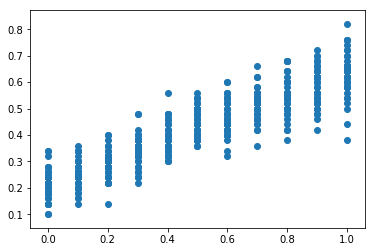

In [255]:
plt.scatter(true_scores_grouped, model_scores_grouped)

In [368]:
# now do the stuff with the color model
model_wd = ImaginativeListener(ColorGeneratorWithDistractors, criterion=torch.nn.CosineEmbeddingLoss, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)
model_wd.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                color_in_dim=54, color_hidden_dim=100)

In [377]:
train = True
model_file_wd = "../model/imaginative_listener_with_distractors100hd10epoch.params"


if train:
    print("Training model and saving to {}:".format(model_file_wd))
    model_wd.fit(train_features, train_targets)
    model_wd.save_model(model_file_wd)
else:
    print("Loading pretrained model")
    model_wd.load_model(model_file_wd)

Training model and saving to ../model/imaginative_listener_with_distractors100hd10epoch.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0000
0m 10s (0:1000 6.38%) 0.0303
0m 21s (0:2000 12.77%) 0.0299
0m 33s (0:3000 19.15%) 0.0370
0m 46s (0:4000 25.53%) 0.0367
0m 58s (0:5000 31.92%) 0.0417
1m 12s (0:6000 38.30%) 0.0327
1m 25s (0:7000 44.69%) 0.0304
1m 39s (0:8000 51.07%) 0.0340
1m 53s (0:9000 57.45%) 0.0288
2m 7s (0:10000 63.84%) 0.0314
2m 21s (0:11000 70.22%) 0.0306
2m 35s (0:12000 76.60%) 0.0296
2m 48s (0:13000 82.99%) 0.0319
3m 1s (0:14000 89.37%) 0.0306
3m 15s (0:15000 95.75%) 0.0313
---EPOCH 1---
3m 25s (1:0 0.00%) 0.0000
3m 38s (1:1000 6.38%) 0.0284
3m 52s (1:2000 12.77%) 0.0305
4m 6s (1:3000 19.15%) 0.0377
4m 21s (1:4000 25.53%) 0.0348
4m 35s (1:5000 31.92%) 0.0426
4m 51s (1:6000 38.30%) 0.0324
5m 5s (1:7000 44.69%) 0.0299
5m 19s (1:8000 51.07%) 0.0332
5m 34s (1:9000 57.45%) 0.0297
5m 51s (1:10000 63.84%) 0.0312
6m 5s (1:11000 70.22%) 0.0290
6m 21s (1:12000 76.60%) 0.0297
6m 40s (1:130

In [378]:
assess_features = feature_handler.test_features()
assess_targets = feature_handler.test_targets()

In [379]:
assess_model_outputs = model_wd.predict(assess_features)

In [307]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(-0.8354280107536605, 5.592060033096995e-136)


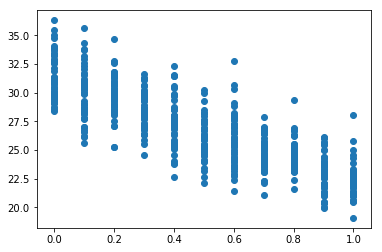

In [308]:
plt.scatter(true_scores_grouped, model_scores_grouped)

In [309]:
# eval score test (i.e. score is whether or not the target is the closest thing to the generated color)
assess_features_eval = feature_handler_eval.test_features()
assess_targets_eval = feature_handler_eval.test_targets()
assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)

(0.8842307551722517, 2.0955729068671075e-172)


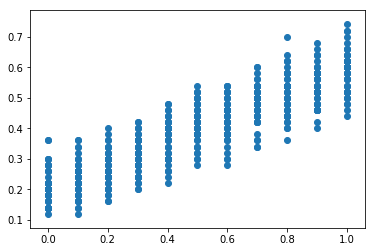

In [310]:
plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)

In [ ]:
# Can we make a custom loss function to optimize for the de-CIEDE2000 score directly? No. It's not differentiable

In [380]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(-0.8010677143533107, 7.199161453242336e-117)


round 1


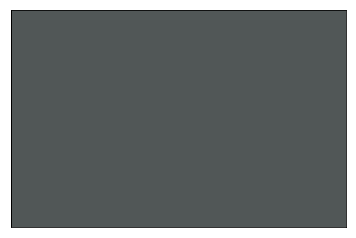

round 2


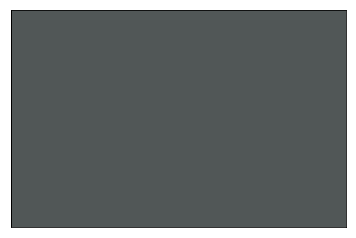

round 3


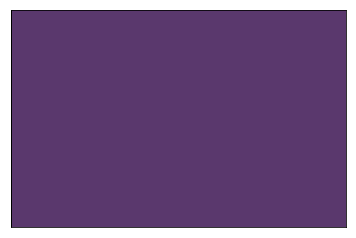

round 4


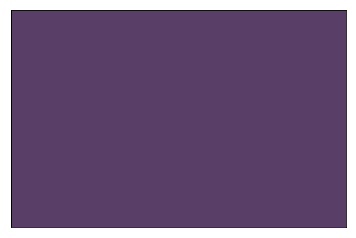

round 5


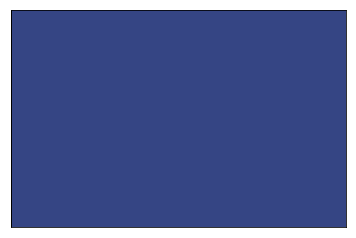

round 6


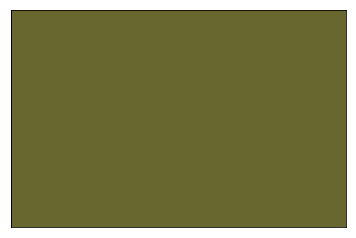

round 7


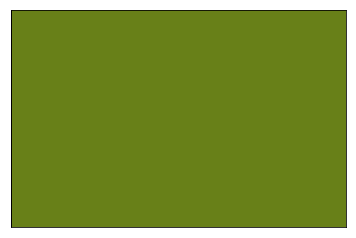

round 8


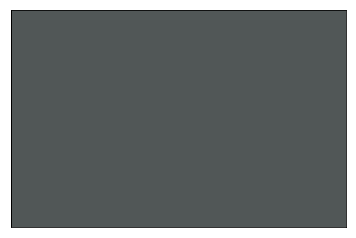

round 9


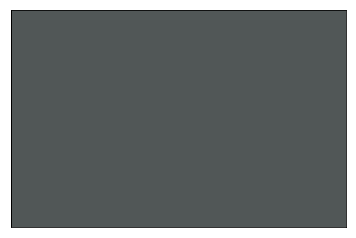

round 10


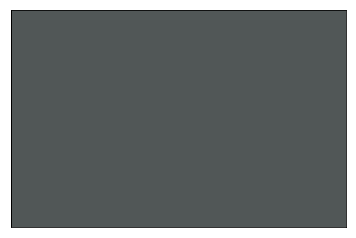

round 11


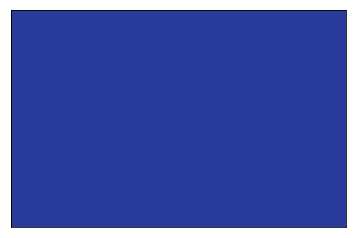

round 12


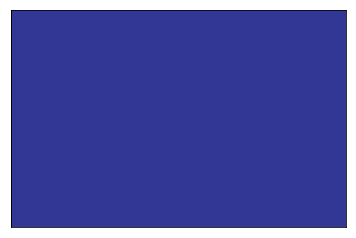

round 13


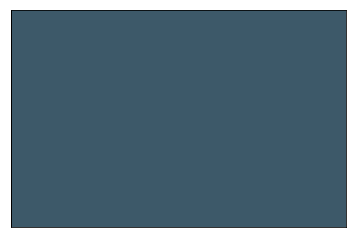

round 14


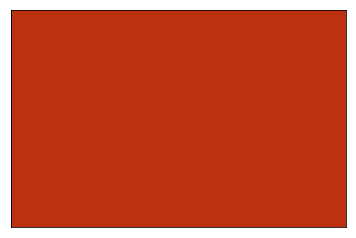

round 15


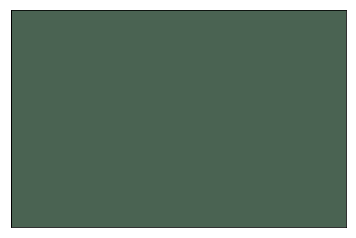

round 16


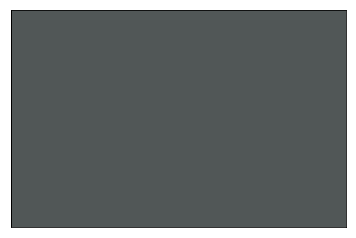

round 17


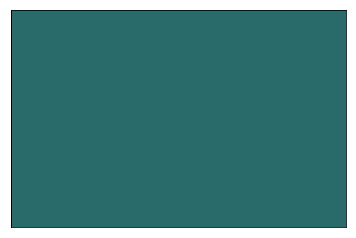

round 18


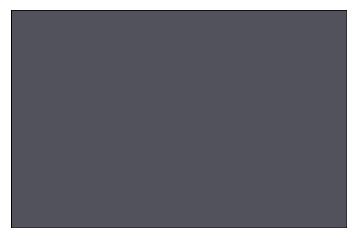

round 19


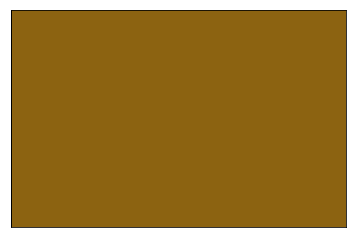

round 20


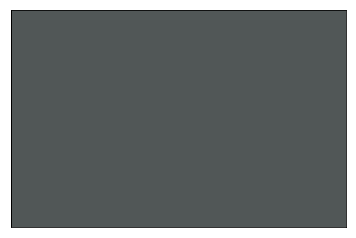

round 21


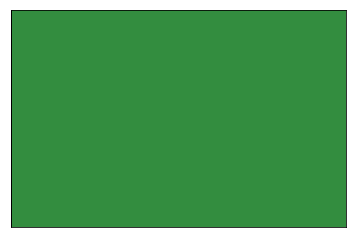

round 22


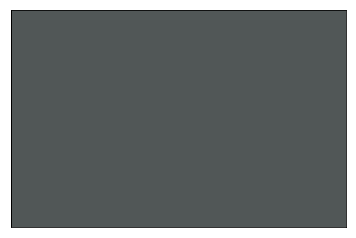

round 23


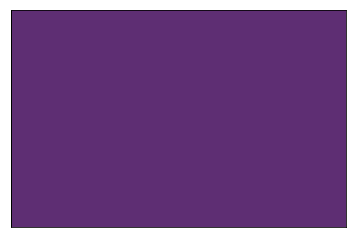

round 24


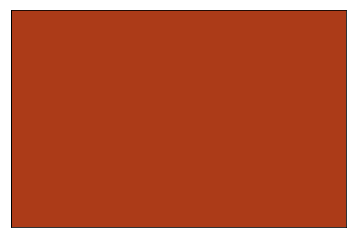

round 25


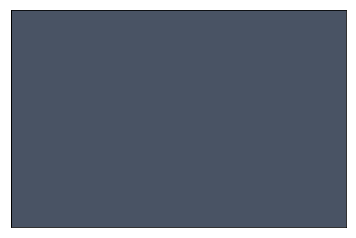

round 26


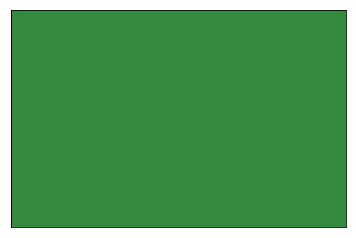

round 27


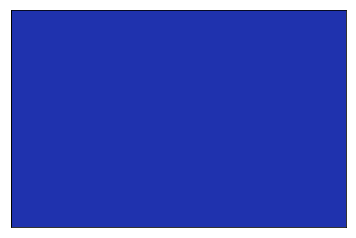

round 28


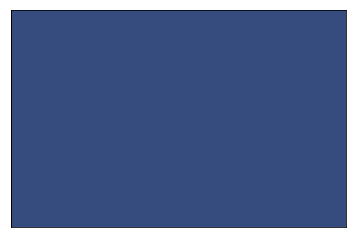

round 29


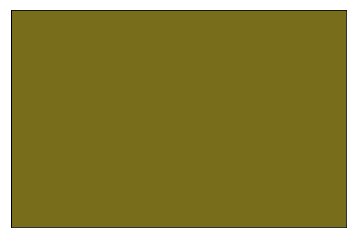

round 30


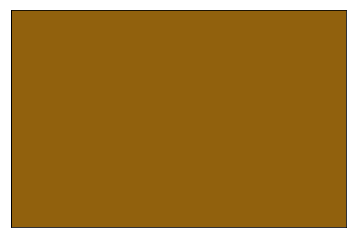

round 31


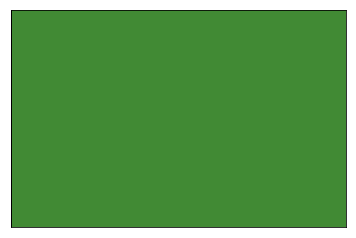

round 32


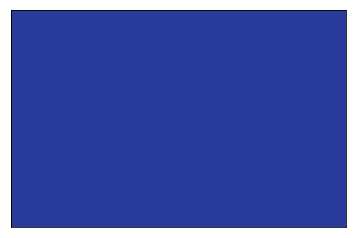

round 33


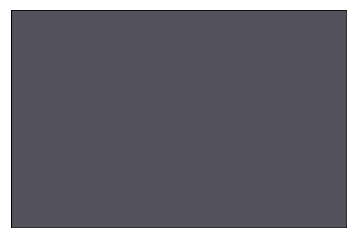

round 34


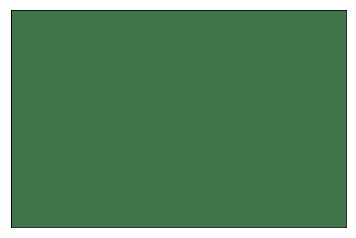

round 35


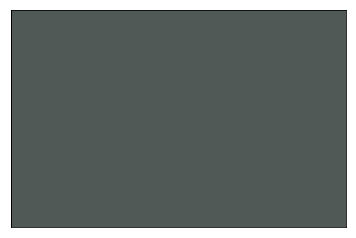

round 36


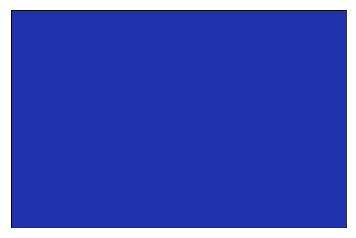

round 37


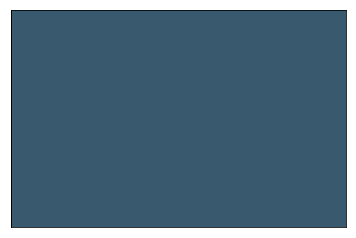

round 38


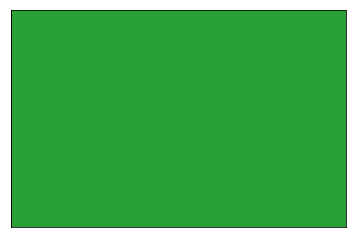

round 39


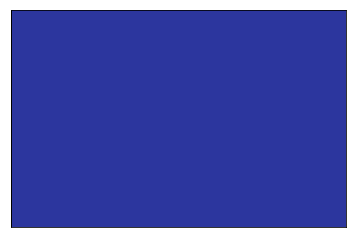

round 40


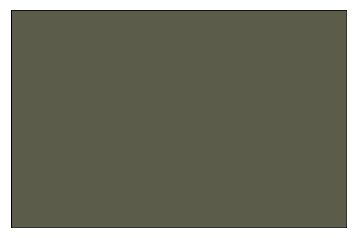

round 41


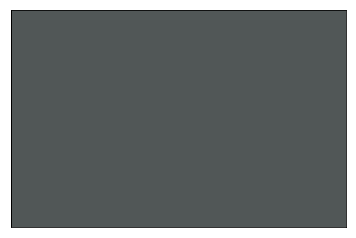

round 42


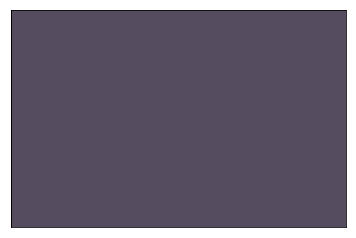

round 43


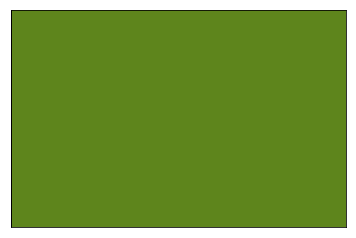

round 44


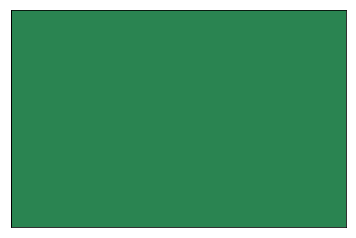

round 45


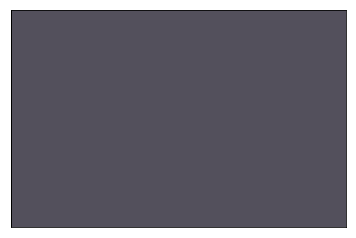

round 46


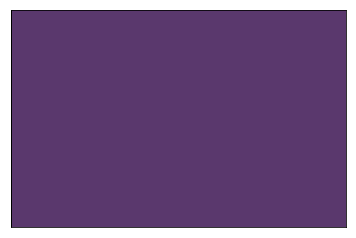

round 47


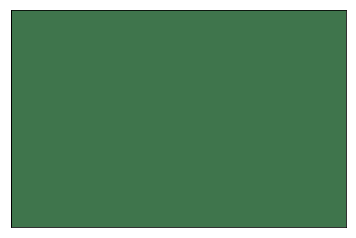

round 48


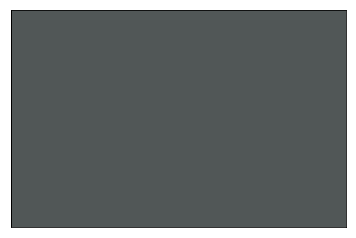

round 49


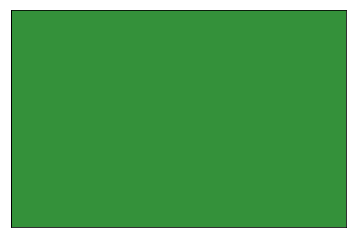

round 50


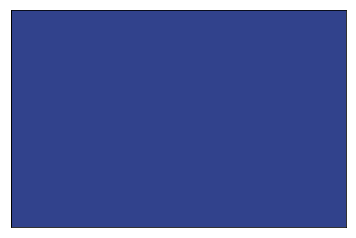

In [381]:
for i in range(50):
    train_data.display_target(assess_model_outputs[i], "round %d"%(i+1))

In [382]:
# let's try to bring in glove (bc why not?)
# author: Chris Potts:
def glove2dict(src_filename):
    """GloVe Reader.
    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.
    Returns
    -------
    dict
        Mapping words to their GloVe vectors.
    """
    data = {}
    with open(src_filename) as f:
        while True:
            try:
                line = next(f)
                line = line.strip().split()
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

In [ ]:
glove100 = glove2dict("../data/glove.6B.100d.txt")

In [388]:
# from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
weight_matrix = np.empty((feature_handler.caption_featurizer.caption_indexer.size, 100))
for i, word in feature_handler.caption_featurizer.caption_indexer.idx2word.items():
    weight_matrix[i] = glove100.get(word, np.random.normal(scale=0.6, size=(100, )))

In [391]:
weight_matrix[2]

array([-1.9250e-01,  4.8191e-01,  2.4200e-01, -2.8813e-01,  4.2773e-01,
        6.6492e-01, -3.9417e-01,  4.5795e-01, -2.4519e-01,  7.1526e-03,
       -1.5636e-01, -1.3484e-01,  4.3403e-01,  3.0483e-01,  5.8961e-01,
        2.5814e-02,  3.9088e-01, -2.2635e-01,  9.0327e-01, -4.0662e-01,
        3.0182e-01, -1.8100e-01, -1.8001e-01, -8.0783e-01,  9.2588e-01,
        9.4471e-01,  4.0950e-01, -3.4413e-01, -2.8963e-01, -9.0913e-02,
        5.3241e-01, -6.2725e-01, -5.3168e-01, -9.1398e-01,  1.0846e-01,
        7.3425e-01,  6.9563e-02,  2.2437e-01,  9.7875e-01,  2.6469e-01,
        2.2588e-01, -9.3845e-01, -3.7150e-01,  1.1159e-01,  9.1055e-02,
       -1.5654e-02, -1.3042e-01,  9.0693e-01,  7.0835e-01, -2.7684e-01,
        4.4326e-01, -3.2484e-01, -1.9900e-02,  1.5055e+00, -3.3263e-02,
       -2.8035e+00,  2.7886e-01,  7.3511e-01,  8.1262e-01,  1.2722e-01,
        6.1194e-04,  1.6790e+00, -5.6488e-01, -3.5005e-01,  9.6566e-01,
       -4.6501e-01,  6.7824e-01, -4.2077e-01, -3.9746e-01, -3.46

In [ ]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

In [396]:
class ColorGeneratorGlove(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, weights):
        super(ColorGeneratorGlove, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.embed.load_state_dict({'weight': weights})
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        
    def forward(self, caption):
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)
        output = self.linear1(output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output
        

In [413]:
model = ImaginativeListener(ColorGeneratorGlove, criterion=torch.nn.CosineEmbeddingLoss, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=False)
model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                weights=torch.tensor(weight_matrix))

In [414]:
train = False
model_file = "../model/imaginative_listener_5epoch_GLOVE.params"


if train:
    print("Training model and saving to {}:".format(model_file))
    model.fit(train_features, train_targets)
    model.save_model(model_file)
else:
    print("Loading pretrained model")
    model.load_model(model_file)

Loading pretrained model


In [402]:
assess_model_outputs = model.predict(assess_features)

In [403]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(-0.8600131253362067, 1.3454943844967891e-152)


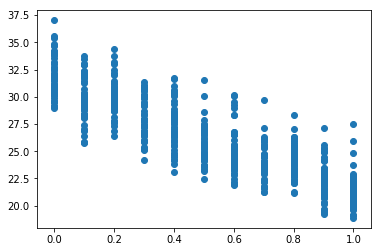

In [404]:
plt.scatter(true_scores_grouped, model_scores_grouped)

round 1


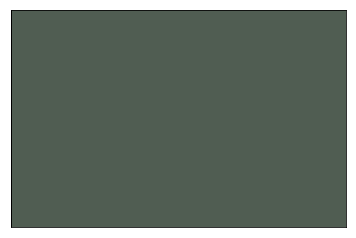

round 2


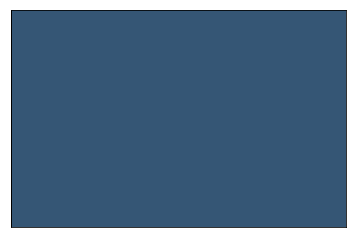

round 3


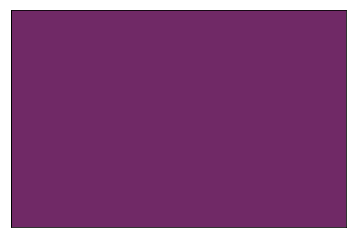

round 4


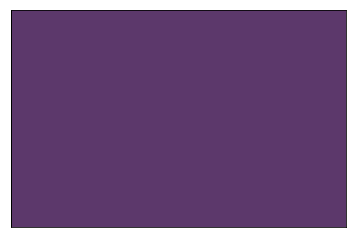

round 5


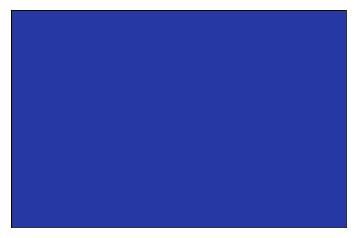

round 6


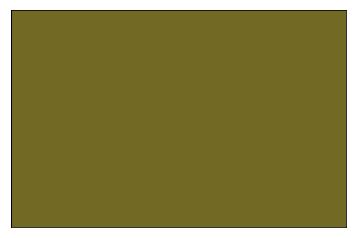

round 7


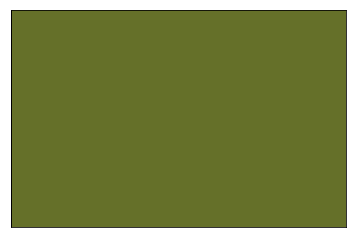

round 8


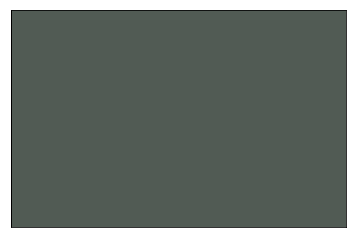

round 9


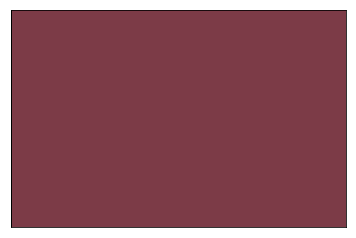

round 10


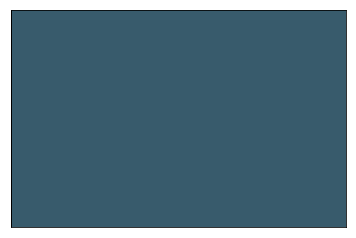

round 11


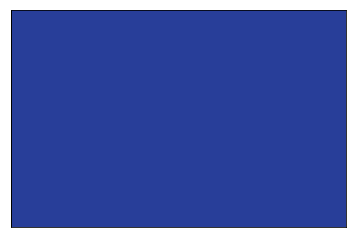

round 12


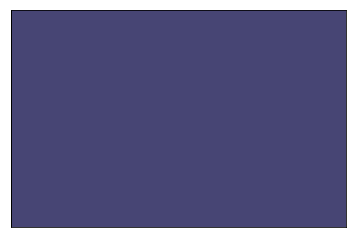

round 13


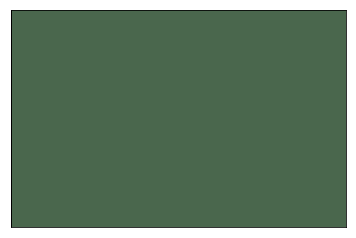

round 14


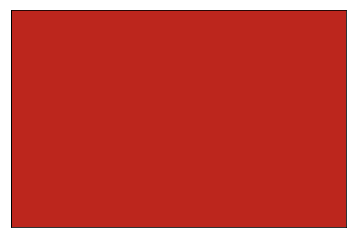

round 15


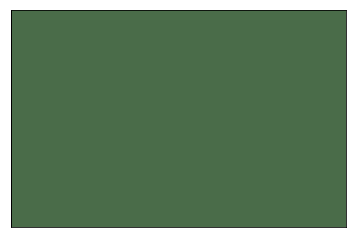

round 16


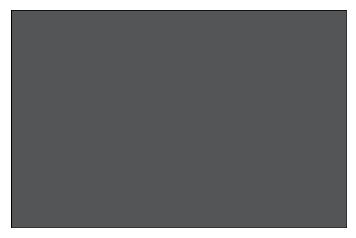

round 17


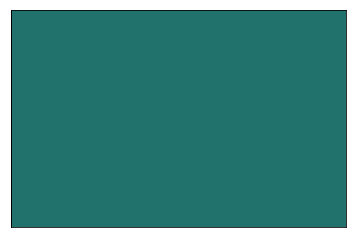

round 18


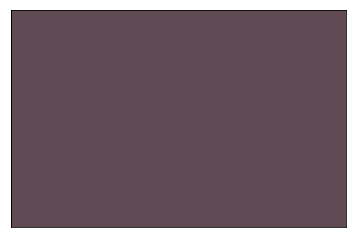

round 19


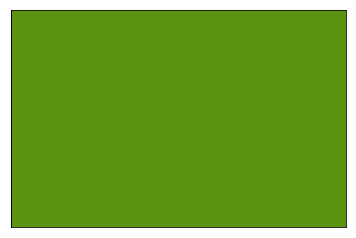

round 20


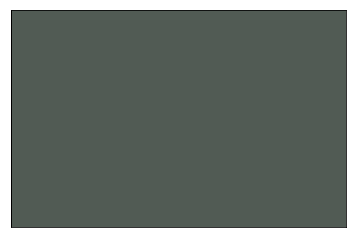

round 21


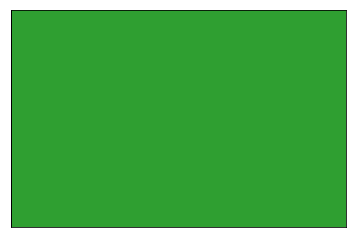

round 22


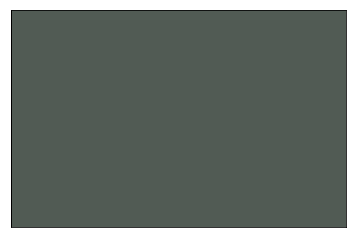

round 23


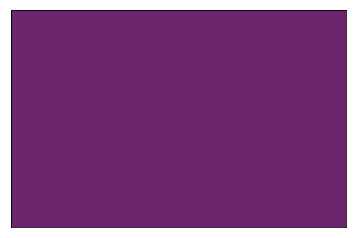

round 24


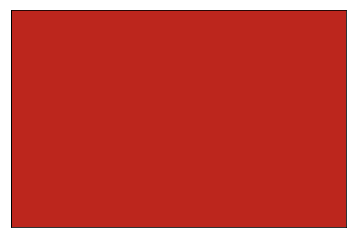

round 25


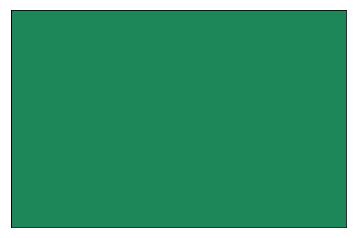

round 26


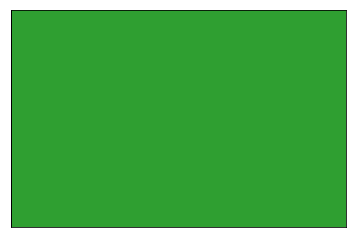

round 27


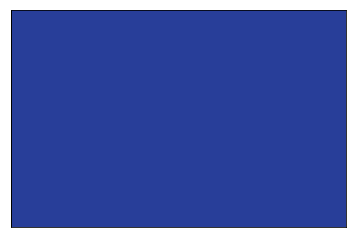

round 28


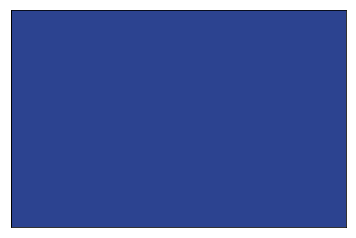

round 29


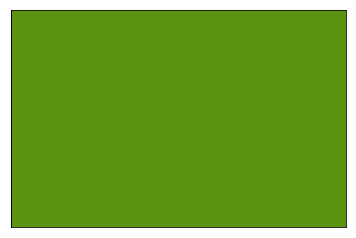

round 30


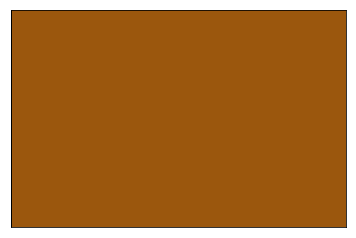

round 31


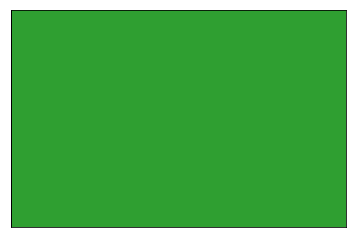

round 32


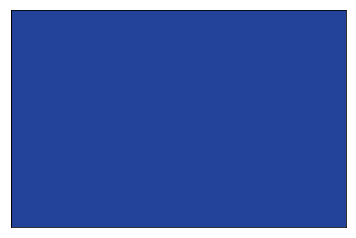

round 33


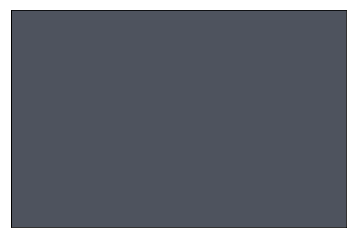

round 34


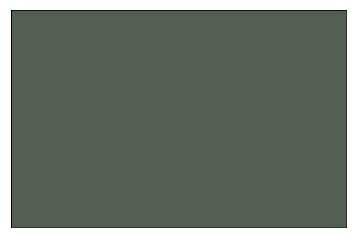

round 35


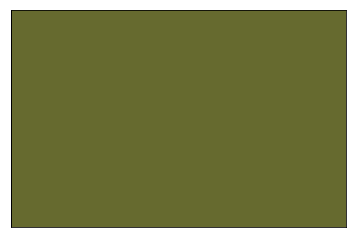

round 36


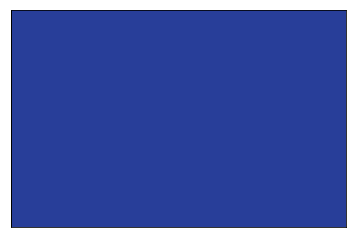

round 37


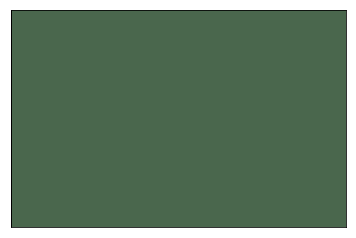

round 38


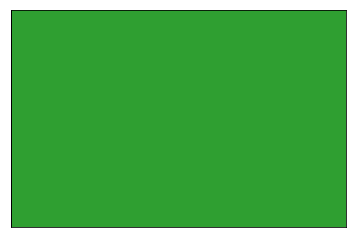

round 39


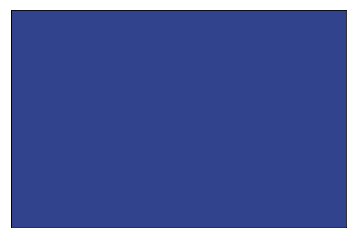

round 40


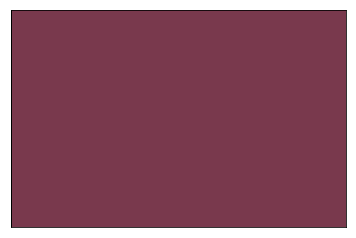

round 41


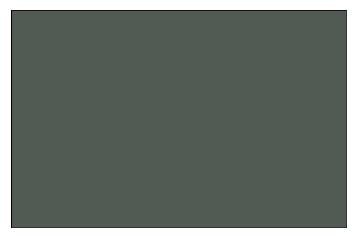

round 42


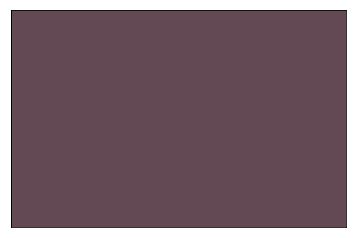

round 43


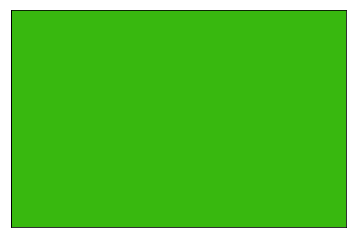

round 44


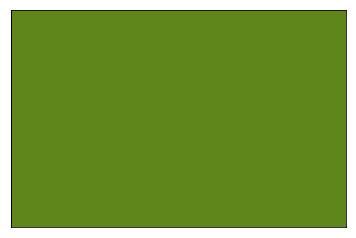

round 45


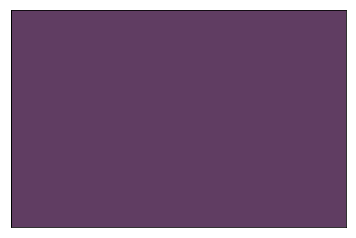

round 46


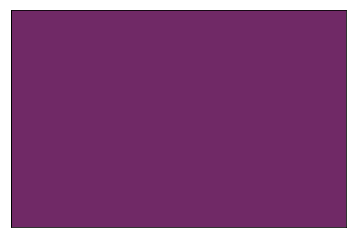

round 47


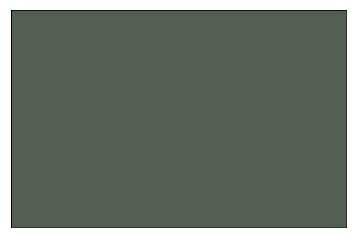

round 48


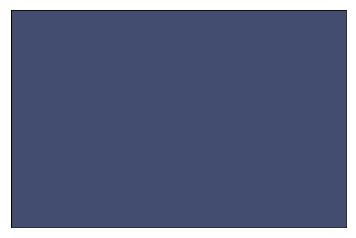

round 49


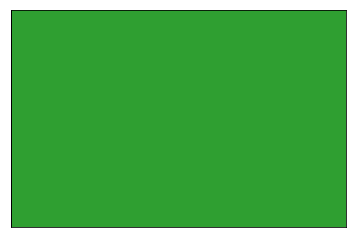

round 50


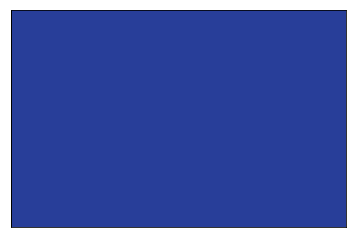

In [405]:
for i in range(50):
    train_data.display_target(assess_model_outputs[i], "round %d"%(i+1))

In [439]:
# training with cosine loss is kind of dumb... we actually do care about the magnitude difference between
# the color vectors and not just the angle, So I'm going to use MSE loss now
MSELossSum = lambda: nn.MSELoss(reduction='sum') # sorry for this ugliness..... but this is me passing a parameter to the loss func
model = ImaginativeListener(ColorGeneratorGlove, criterion=MSELossSum, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=False)
model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                weights=torch.tensor(weight_matrix))

In [443]:
train = False
model_file = "../model/imaginative_listener_5epoch_GLOVE_MSE.params"


if train:
    print("Training model and saving to {}:".format(model_file))
    model.fit(train_features, train_targets)
    model.save_model(model_file)
else:
    print("Loading pretrained model")
    model.load_model(model_file)

Loading pretrained model


In [434]:
assess_model_outputs = model.predict(assess_features)

In [435]:
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(-0.8622546297194225, 2.8660889143360326e-154)


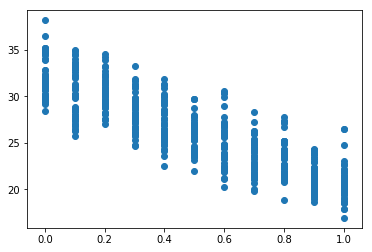

In [436]:
plt.scatter(true_scores_grouped, model_scores_grouped)

(0.9245488247218627, 6.215139164913941e-218)


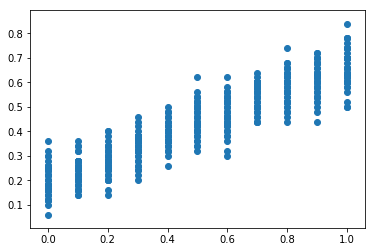

In [445]:
# eval score test (i.e. score is whether or not the target is the closest thing to the generated color)
# assess_features_eval = feature_handler_eval.test_features()
# assess_targets_eval = feature_handler_eval.test_targets()
assess_model_outputs = model.predict(assess_features)
assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)
plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)

round 1


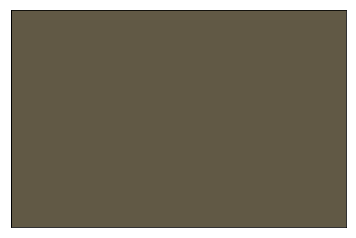

round 2


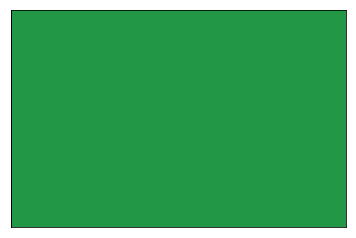

round 3


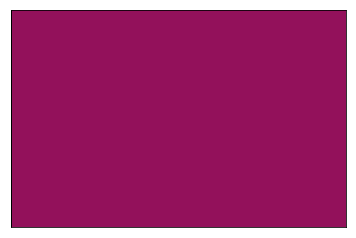

round 4


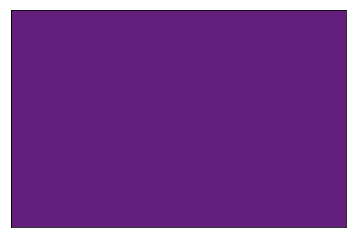

round 5


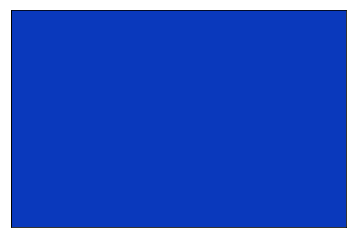

round 6


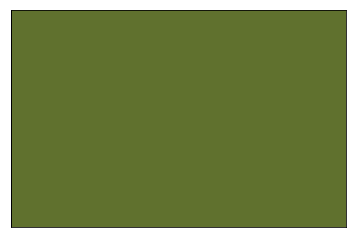

round 7


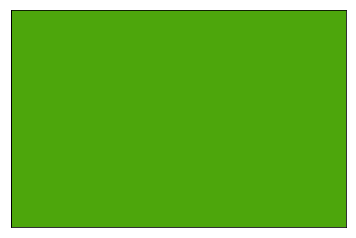

round 8


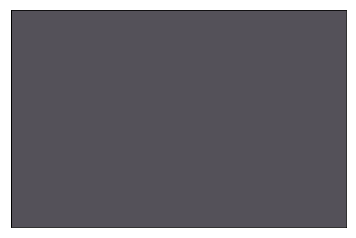

round 9


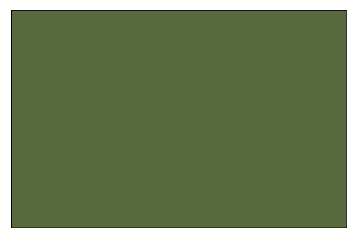

round 10


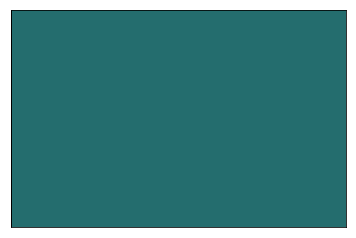

round 11


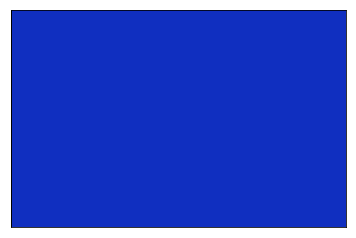

round 12


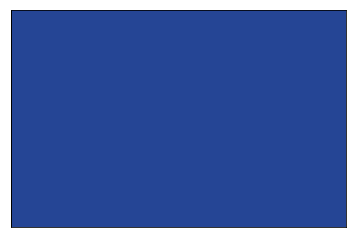

round 13


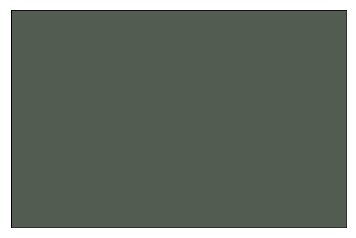

round 14


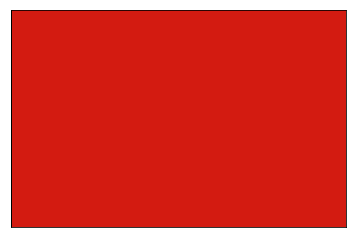

round 15


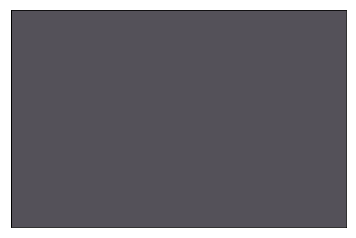

round 16


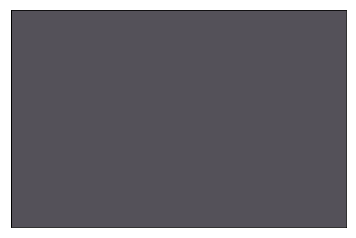

round 17


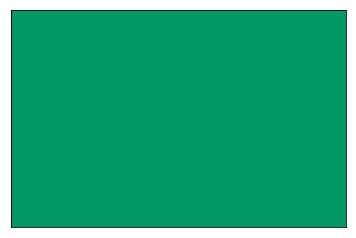

round 18


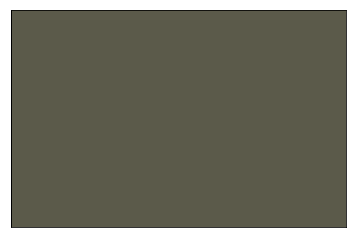

round 19


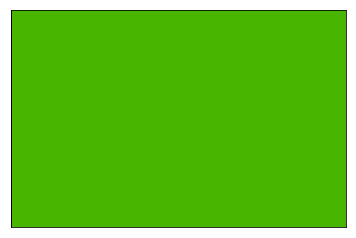

round 20


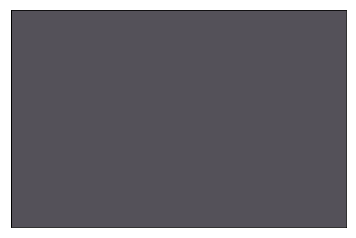

round 21


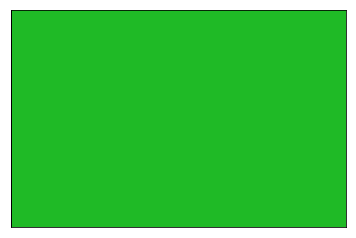

round 22


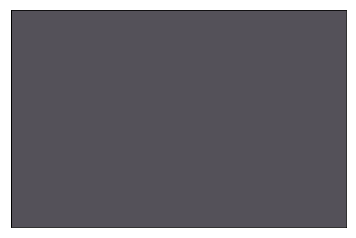

round 23


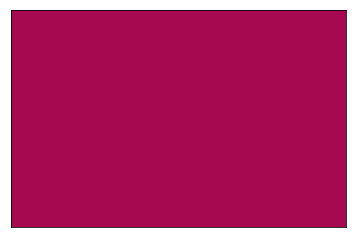

round 24


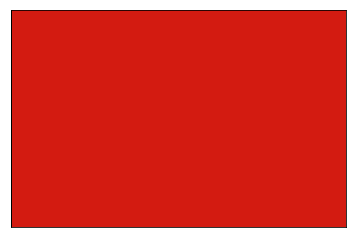

round 25


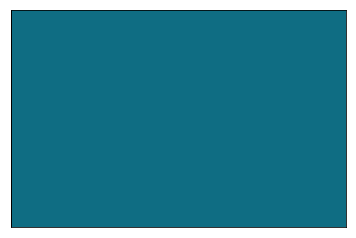

round 26


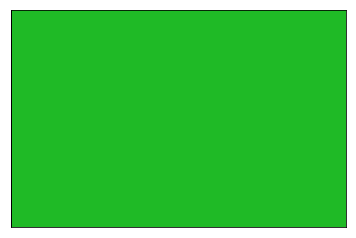

round 27


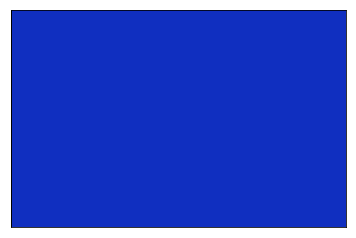

round 28


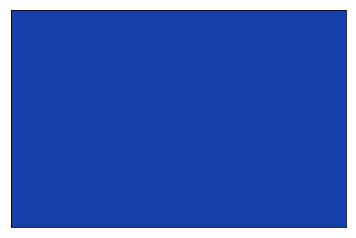

round 29


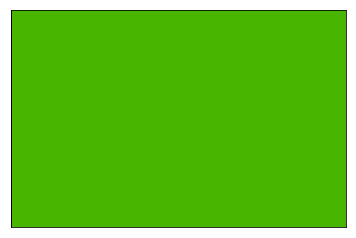

round 30


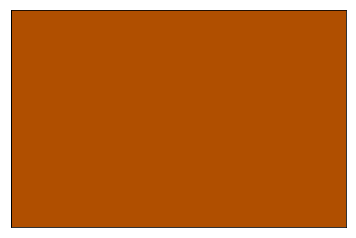

round 31


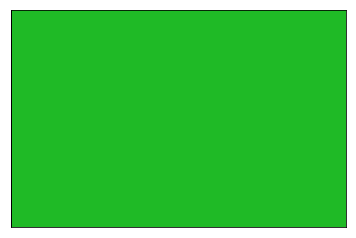

round 32


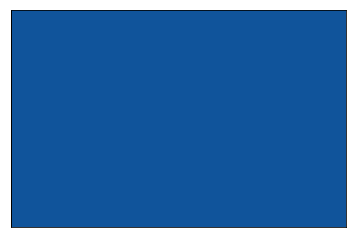

round 33


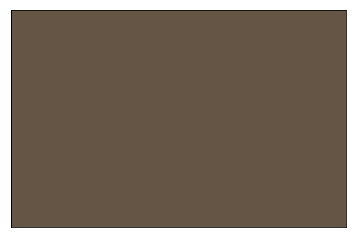

round 34


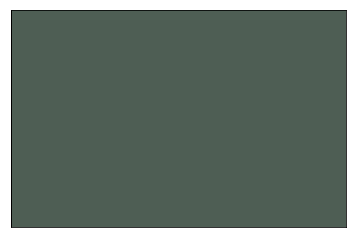

round 35


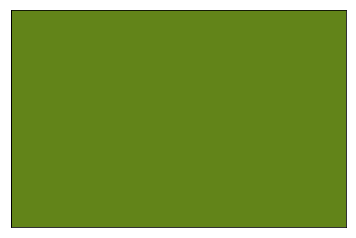

round 36


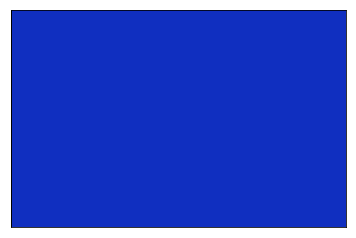

round 37


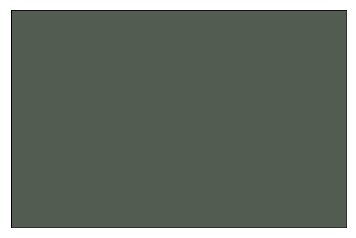

round 38


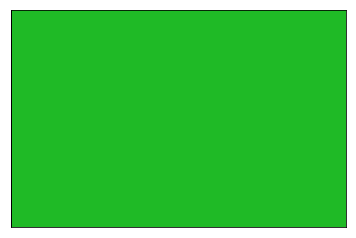

round 39


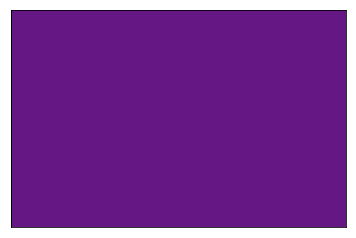

round 40


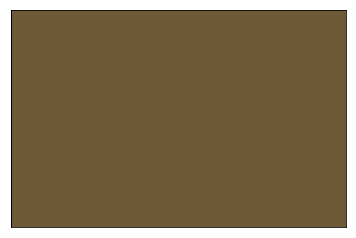

round 41


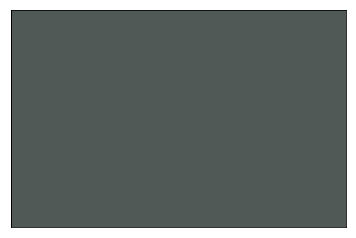

round 42


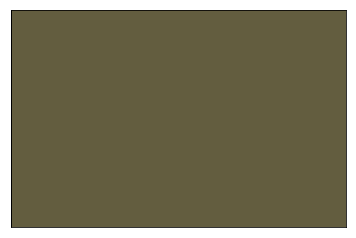

round 43


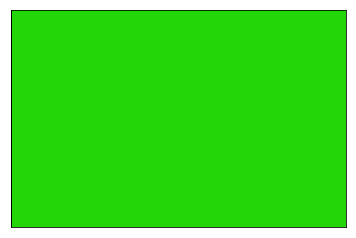

round 44


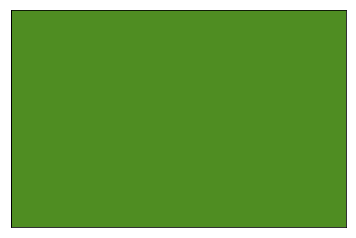

round 45


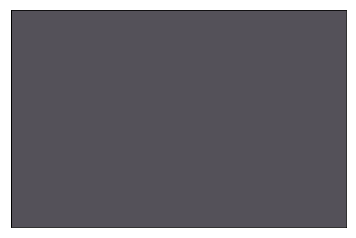

round 46


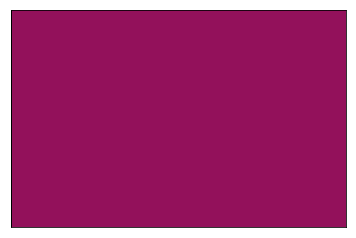

round 47


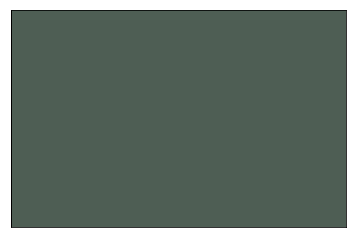

round 48


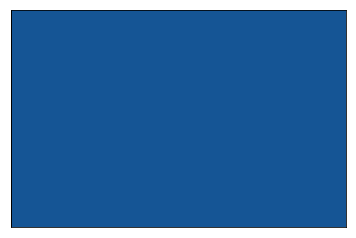

round 49


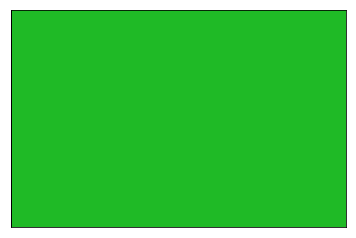

round 50


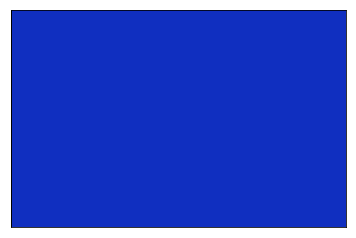

In [437]:
for i in range(50):
    train_data.display_target(assess_model_outputs[i], "round %d"%(i+1))

0) Game: synth-0 Round: 1
concrete


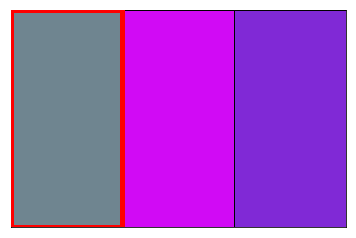

1) Game: synth-0 Round: 2
the concrete mixed with sky


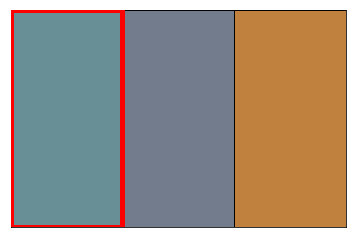

2) Game: synth-0 Round: 3
pink


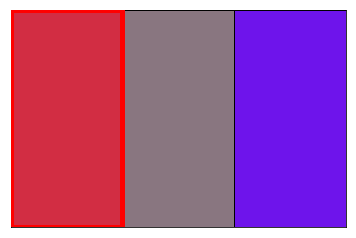

3) Game: synth-0 Round: 4
the dullest purple


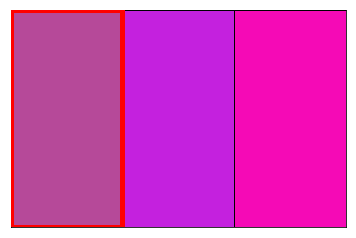

4) Game: synth-0 Round: 5
the brighter blue


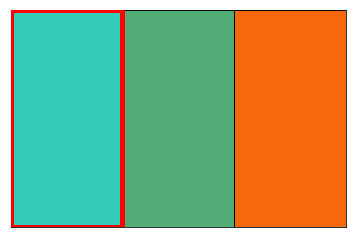

5) Game: synth-0 Round: 6
brown/orange


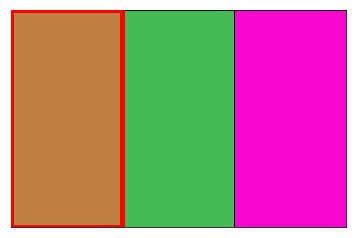

6) Game: synth-0 Round: 7
the yellowest one


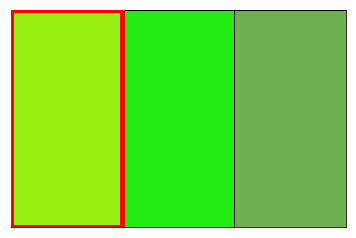

7) Game: synth-0 Round: 8
the greyest one


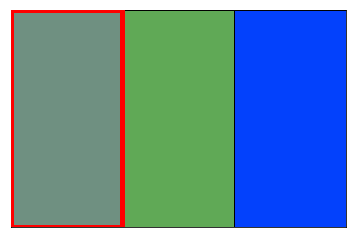

8) Game: synth-0 Round: 9
the brighter lavender


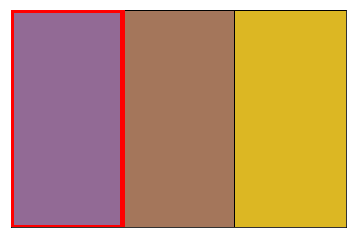

9) Game: synth-0 Round: 10
the most sky of the colors


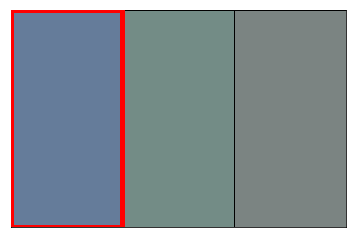

10) Game: synth-0 Round: 11
blue


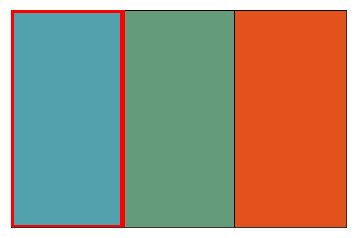

11) Game: synth-0 Round: 12
the purplish blue


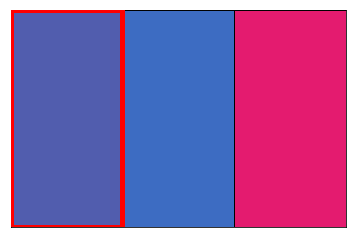

12) Game: synth-0 Round: 13
the most intense one


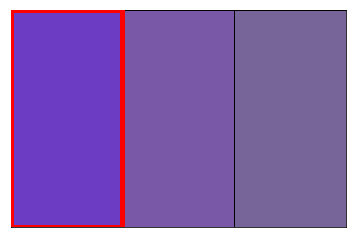

13) Game: synth-0 Round: 14
red


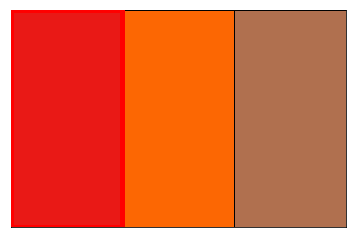

14) Game: synth-0 Round: 15
the more grey green


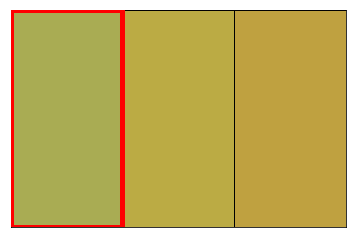

15) Game: synth-0 Round: 16
the greyish blue


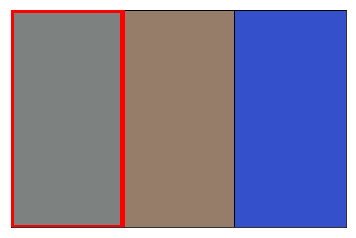

16) Game: synth-0 Round: 17
bright blue green ~ the lighter one


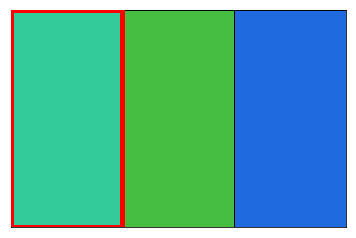

17) Game: synth-0 Round: 18
lavender


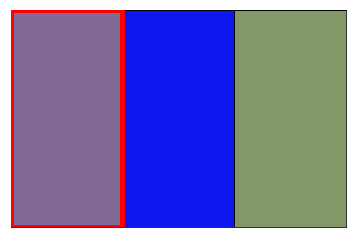

18) Game: synth-0 Round: 19
yellow


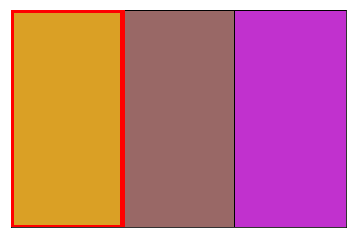

19) Game: synth-0 Round: 20
grey


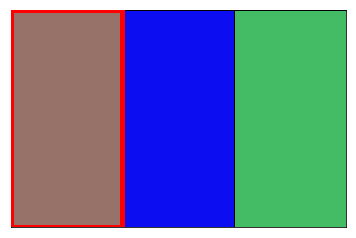

20) Game: synth-0 Round: 21
green


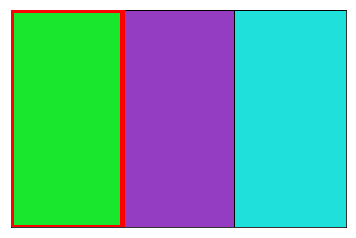

21) Game: synth-0 Round: 22
the bluer grey


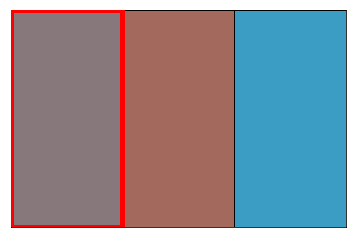

22) Game: synth-0 Round: 23
the pinker pink


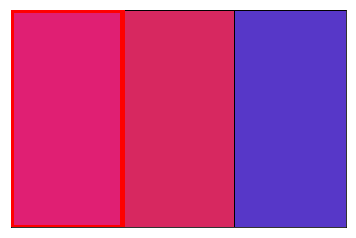

23) Game: synth-0 Round: 24
red


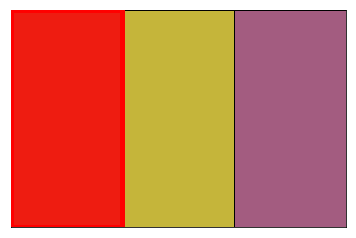

24) Game: synth-0 Round: 25
the duller aqua


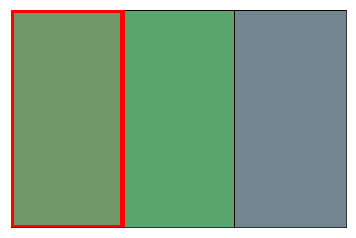

25) Game: synth-0 Round: 26
green


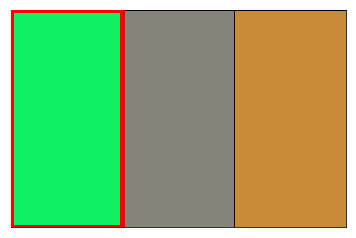

26) Game: synth-0 Round: 27
blue


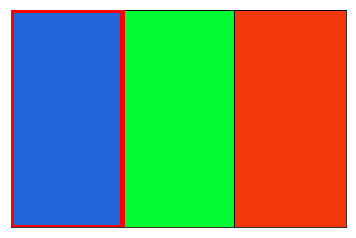

27) Game: synth-0 Round: 28
the most intense blue


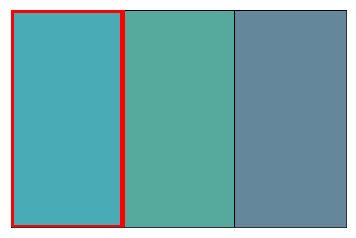

28) Game: synth-0 Round: 29
yellow


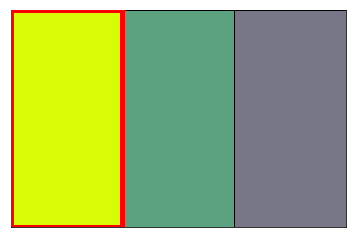

29) Game: synth-0 Round: 30
orange


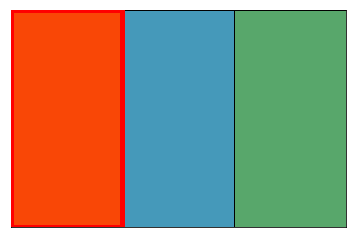

30) Game: synth-0 Round: 31
green


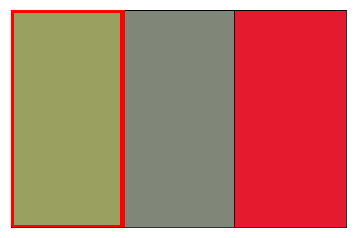

31) Game: synth-0 Round: 32
the lighter blue


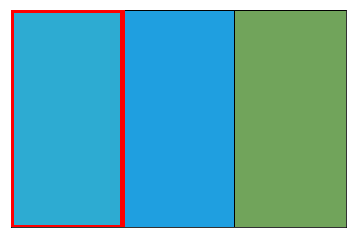

32) Game: synth-0 Round: 33
the dull slightly bluish lavender


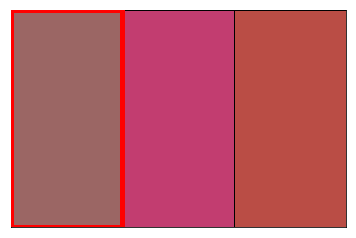

33) Game: synth-0 Round: 34
the brightest one


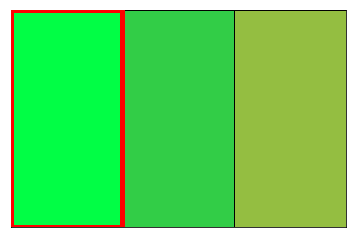

34) Game: synth-0 Round: 35
the one that looks more yellow, but not greyed out


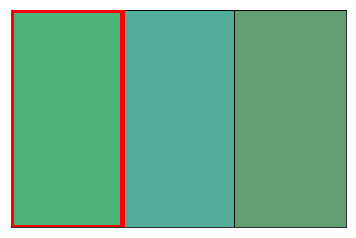

35) Game: synth-0 Round: 36
blue


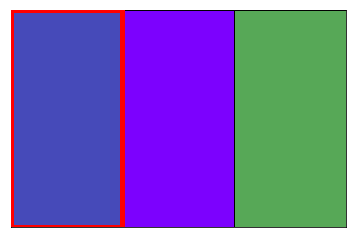

36) Game: synth-0 Round: 37
the most intense one


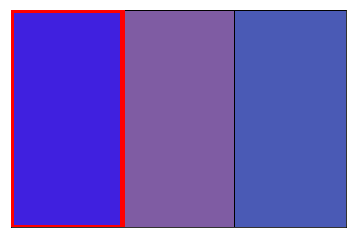

37) Game: synth-0 Round: 38
green


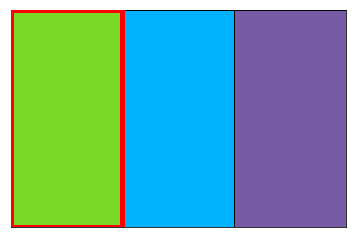

38) Game: synth-0 Round: 39
Royal of the two ~ non the confederate uniform ~ oh darker! more like 'rain'


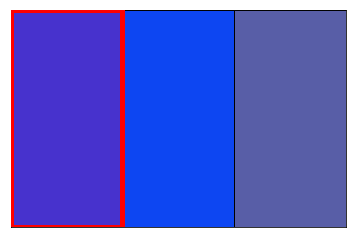

39) Game: synth-0 Round: 40
lavender ~ the duller one


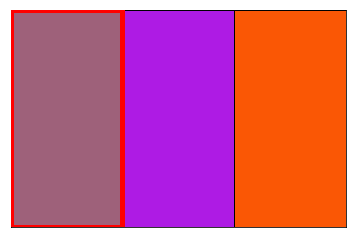

40) Game: synth-0 Round: 41
gray


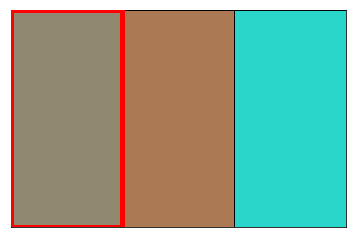

41) Game: synth-0 Round: 42
dull lavender


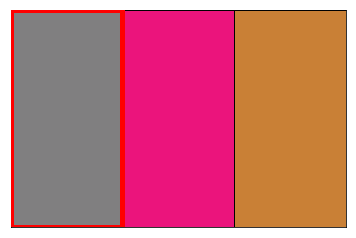

42) Game: synth-0 Round: 43
the yellower green


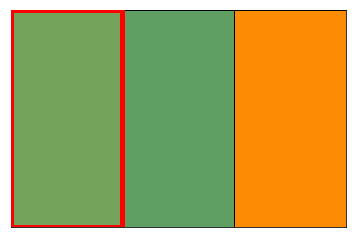

43) Game: synth-0 Round: 44
the most bright and neon looking


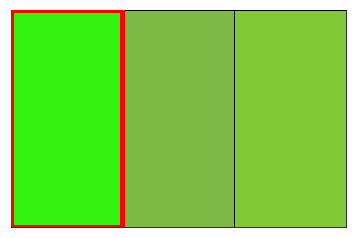

44) Game: synth-0 Round: 45
the dull lavender that is more purplish


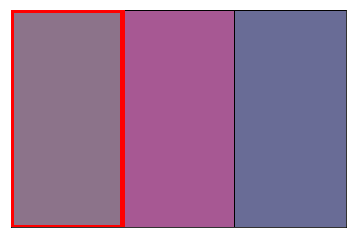

45) Game: synth-0 Round: 46
pink


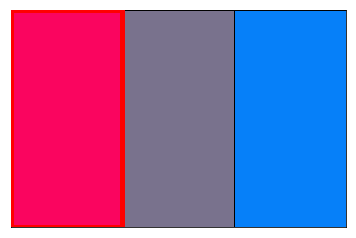

46) Game: synth-0 Round: 47
the brightest one


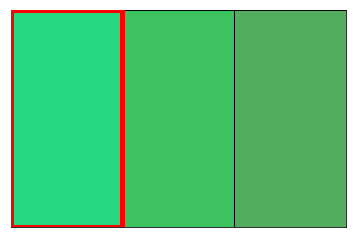

47) Game: synth-0 Round: 48
Concrete ... not with any sky or '....rain'


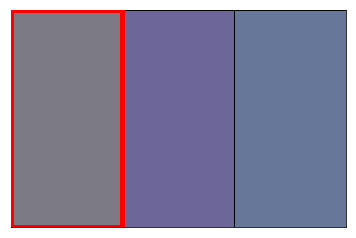

48) Game: synth-0 Round: 49
green


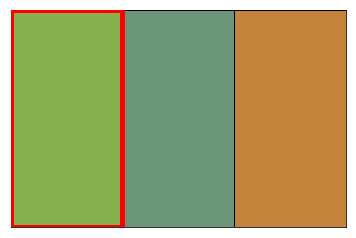

49) Game: synth-0 Round: 50
blue


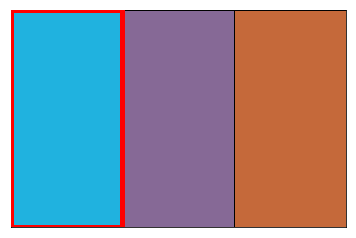

In [438]:
dev_data_synth.display_game_for_gameid("synth-0")

In [440]:
# untrained model
assess_model_outputs = model.predict(assess_features)
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)

(0.06322504945107034, 0.1511318858493755)


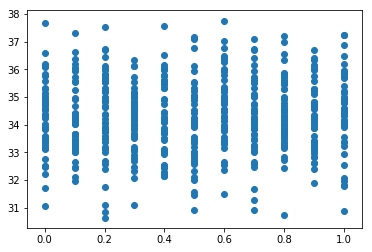

In [441]:
plt.scatter(true_scores_grouped, model_scores_grouped)

(0.032203189593164004, 0.464998148797811)


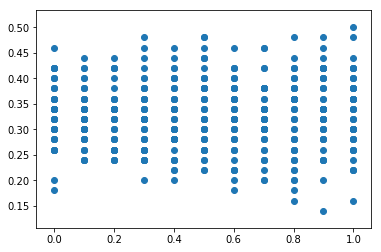

In [442]:
# eval score test (i.e. score is whether or not the target is the closest thing to the generated color)
assess_features_eval = feature_handler_eval.test_features()
assess_targets_eval = feature_handler_eval.test_targets()
assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)
plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)

In [580]:
def assess_model(model):
    # get model outputs
    assess_model_outputs = model.predict(assess_features)
    
    # first do delta e check
    assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)
    _, close_scores, split_scores, far_scores, all_scores = score_model(dev_data_synth, assess_model_scores, score=Score.CONDITION, return_df=True)
#     plt.scatter(true_scores_grouped, model_scores_grouped)
#     plt.show()
    
    # next do accuracy check
    assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)
    _, close_scores_eval, split_scores_eval, far_scores_eval, all_scores_eval = score_model(dev_data_synth, assess_model_scores_eval, score=Score.CONDITION, return_df=True)
    close_scores["model_scores_eval"] = close_scores_eval["model_scores"]
    split_scores["model_scores_eval"] = split_scores_eval["model_scores"]
    far_scores["model_scores_eval"] = far_scores_eval["model_scores"]
    all_scores["model_scores_eval"] = all_scores_eval["model_scores"]
    
    close_scores = close_scores.groupby("gameid").mean()
    split_scores = split_scores.groupby("gameid").mean()
    far_scores = far_scores.groupby("gameid").mean()
    all_scores = all_scores.groupby("gameid").mean()
    
    find_correlation(close_scores, "red", "Close")
    find_correlation(split_scores, "blue", "Split")
    find_correlation(far_scores, "green", "Far")
    find_correlation(all_scores, "black", "All")
    
    # all_scores_eval['model_outputs'] = assess_model_outputs
    return all_scores_eval, assess_model_outputs
    
#     plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)
#     plt.show()

(-0.8622546297194225, 2.8660889143360326e-154)


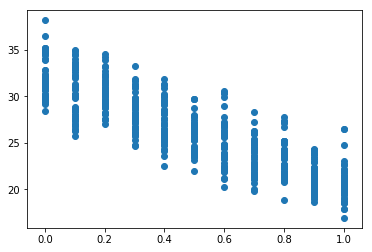

(0.9245488247218627, 6.215139164913941e-218)


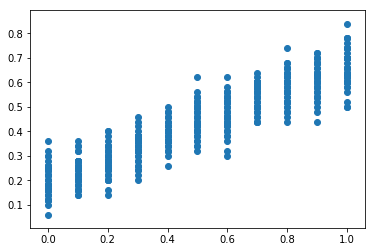

In [447]:
assess_model(model)

In [464]:
# training with cosine loss is kind of dumb... we actually do care about the magnitude difference between
# the color vectors and not just the angle, So I'm going to use MSE loss now
MSELossSum = lambda: nn.MSELoss(reduction='sum') # sorry for this ugliness..... but this is me passing a parameter to the loss func
model = ImaginativeListener(ColorGeneratorWithDistractors, criterion=MSELossSum, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                color_in_dim=54, color_hidden_dim=100, weight_matrix=torch.tensor(weight_matrix))


In [465]:
train = False
model_file = "../model/imaginative_listener_with_dsitractors100hd5epoch_GLOVE_MSE.params"


if train:
    print("Training model and saving to {}:".format(model_file))
    model.fit(train_features, train_targets)
    model.save_model(model_file)
else:
    print("Loading pretrained model")
    model.load_model(model_file)

Loading pretrained model


(-0.8426918788012957, 1.3718608654975358e-140)


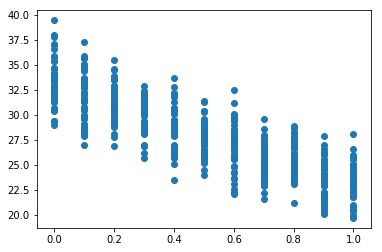

(0.889137187314939, 5.84591507746948e-177)


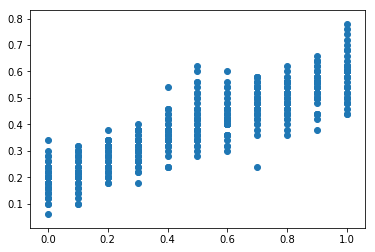

In [457]:
assess_model(model)

round 1


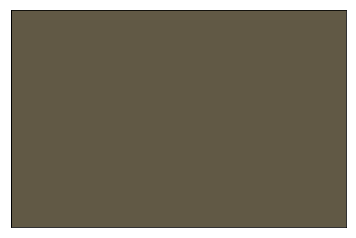

round 2


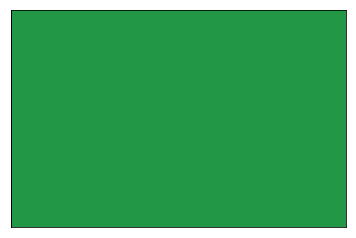

round 3


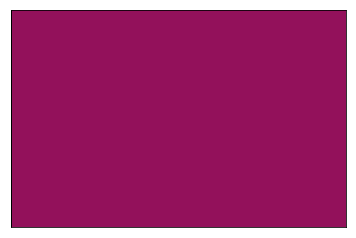

round 4


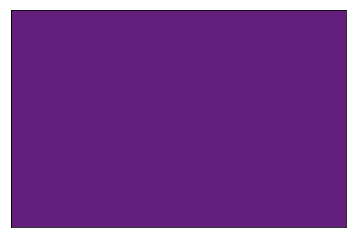

round 5


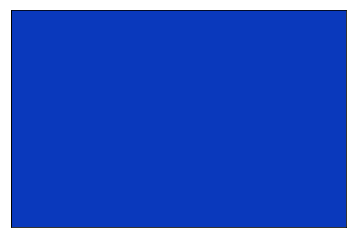

round 6


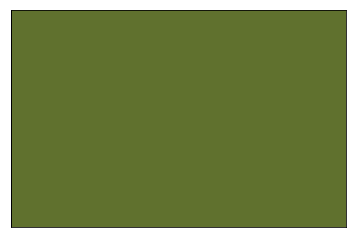

round 7


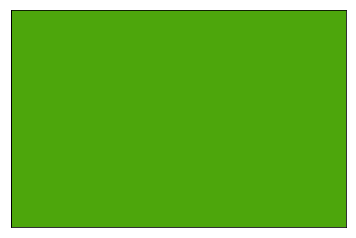

round 8


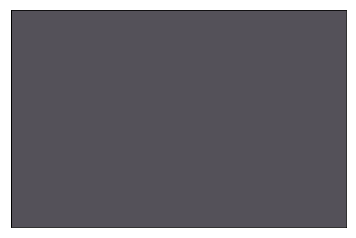

round 9


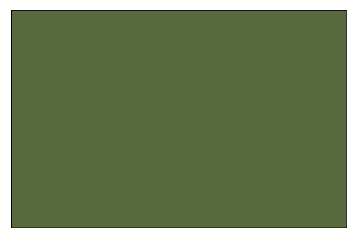

round 10


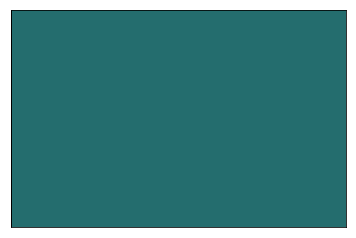

round 11


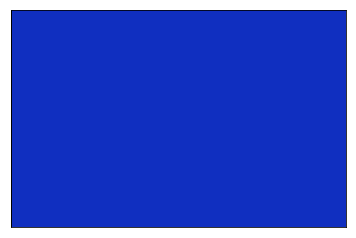

round 12


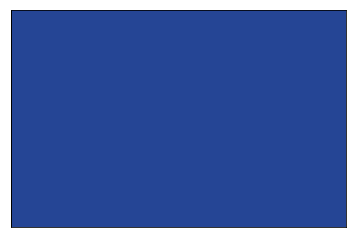

round 13


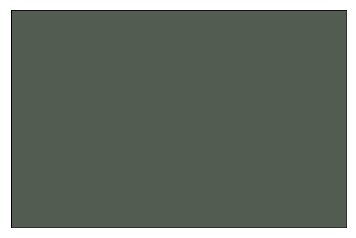

round 14


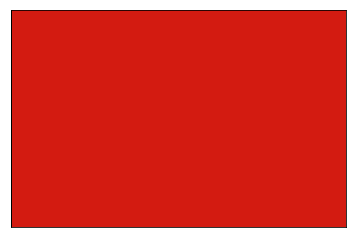

round 15


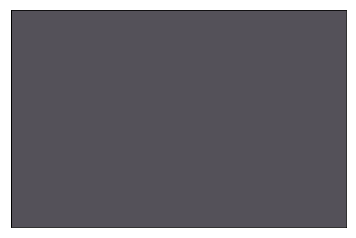

round 16


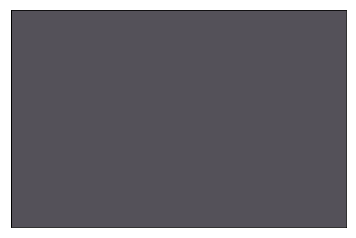

round 17


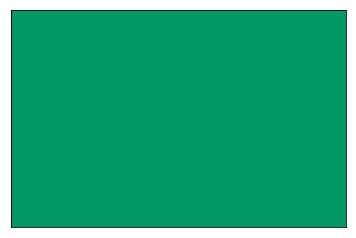

round 18


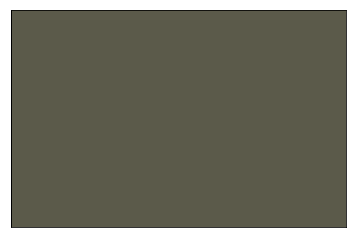

round 19


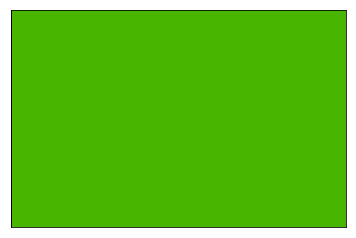

round 20


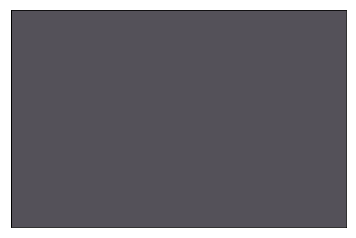

round 21


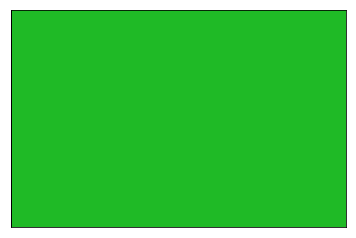

round 22


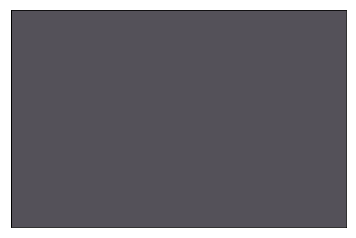

round 23


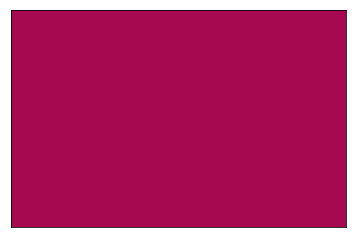

round 24


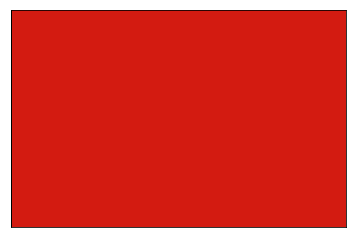

round 25


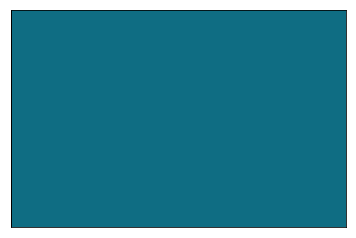

round 26


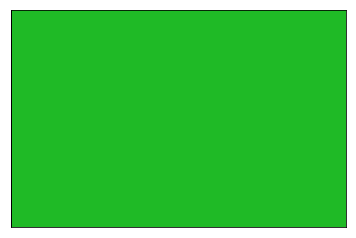

round 27


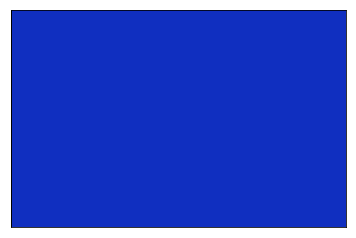

round 28


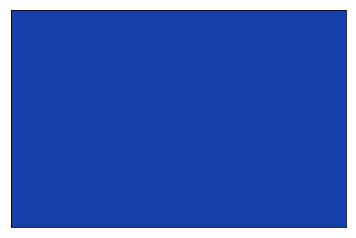

round 29


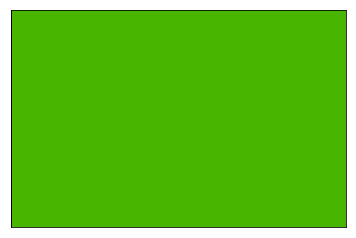

round 30


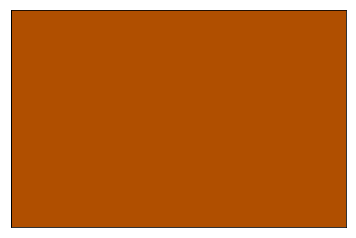

round 31


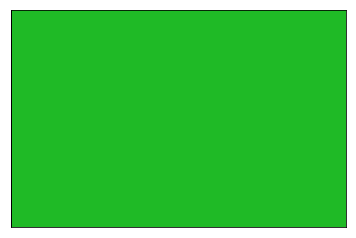

round 32


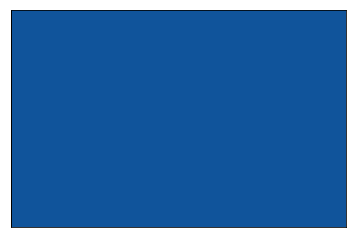

round 33


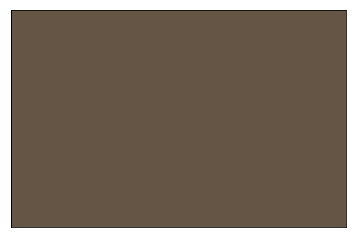

round 34


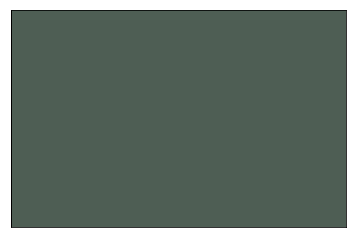

round 35


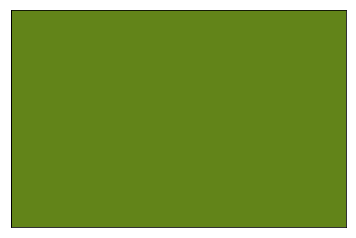

round 36


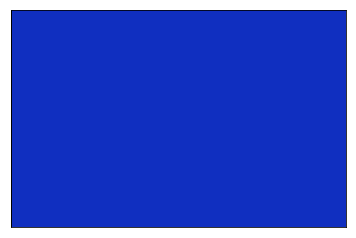

round 37


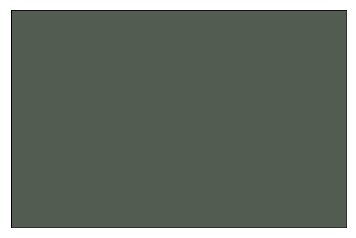

round 38


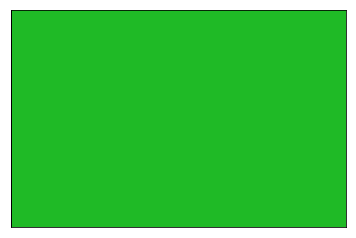

round 39


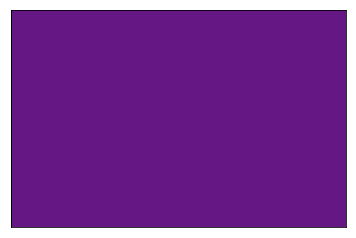

round 40


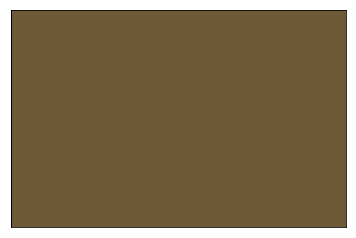

round 41


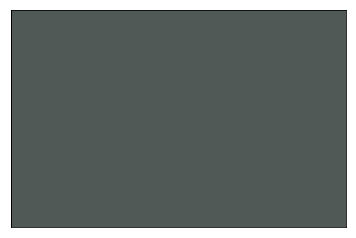

round 42


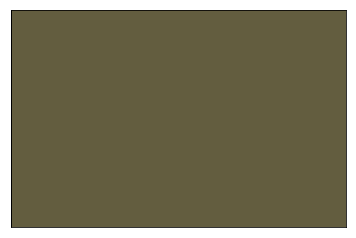

round 43


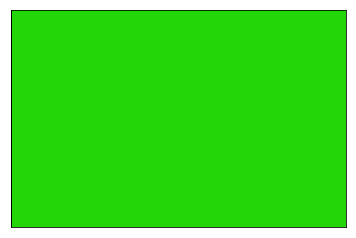

round 44


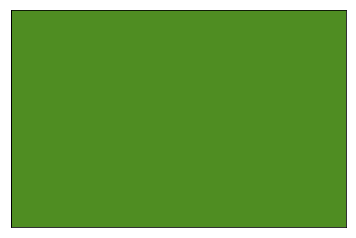

round 45


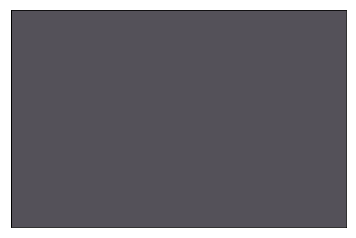

round 46


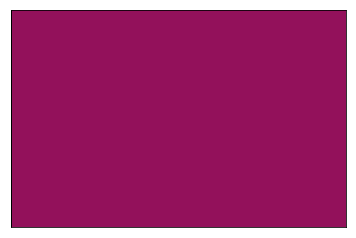

round 47


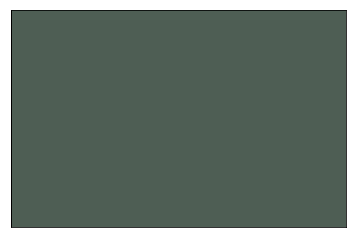

round 48


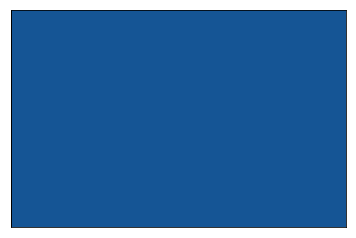

round 49


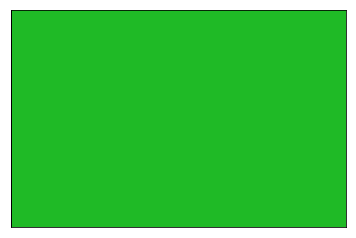

round 50


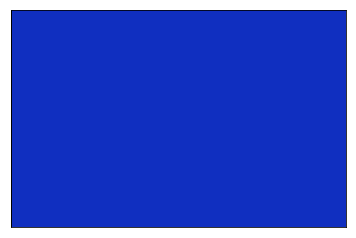

In [466]:
for i in range(50):
    train_data.display_target(assess_model_outputs[i], "round %d"%(i+1))

0) Game: synth-0 Round: 1
concrete


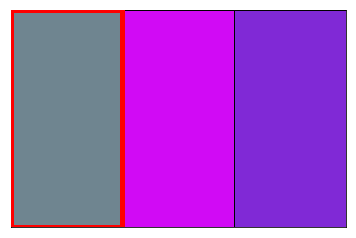

1) Game: synth-0 Round: 2
the concrete mixed with sky


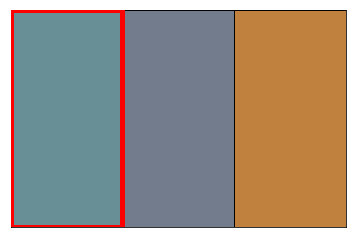

2) Game: synth-0 Round: 3
pink


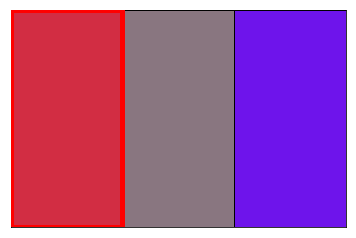

3) Game: synth-0 Round: 4
the dullest purple


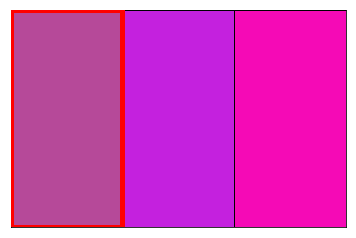

4) Game: synth-0 Round: 5
the brighter blue


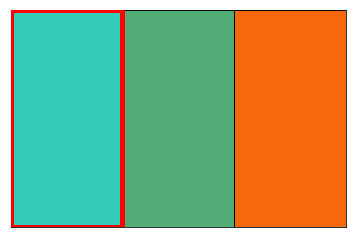

5) Game: synth-0 Round: 6
brown/orange


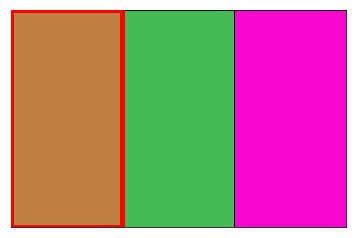

6) Game: synth-0 Round: 7
the yellowest one


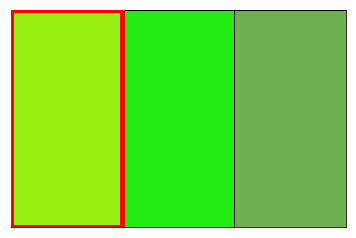

7) Game: synth-0 Round: 8
the greyest one


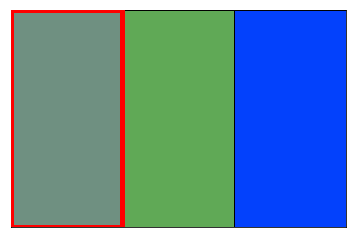

8) Game: synth-0 Round: 9
the brighter lavender


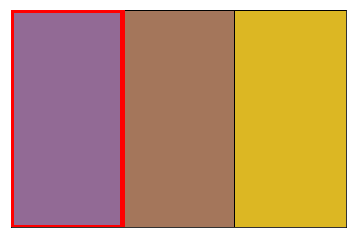

9) Game: synth-0 Round: 10
the most sky of the colors


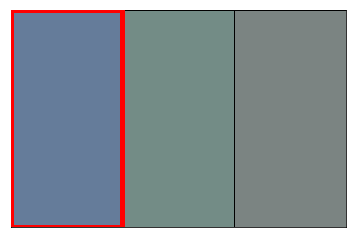

10) Game: synth-0 Round: 11
blue


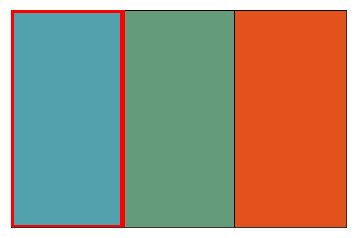

11) Game: synth-0 Round: 12
the purplish blue


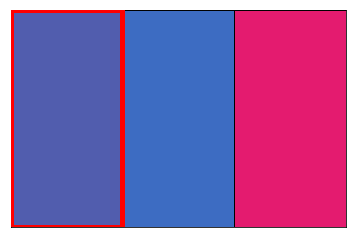

12) Game: synth-0 Round: 13
the most intense one


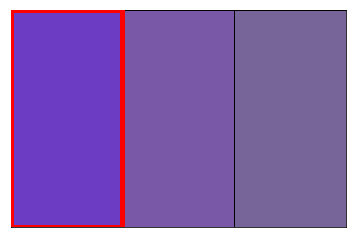

13) Game: synth-0 Round: 14
red


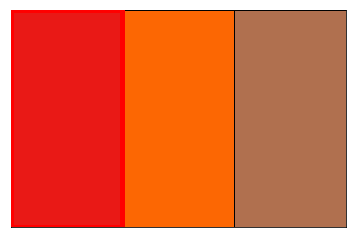

14) Game: synth-0 Round: 15
the more grey green


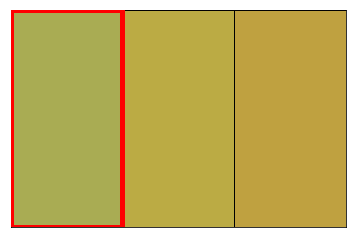

15) Game: synth-0 Round: 16
the greyish blue


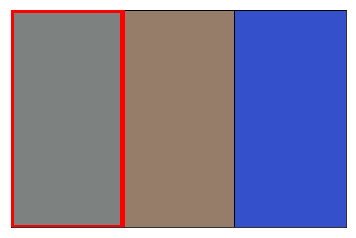

16) Game: synth-0 Round: 17
bright blue green ~ the lighter one


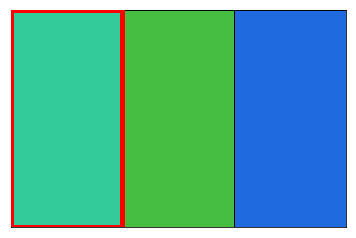

17) Game: synth-0 Round: 18
lavender


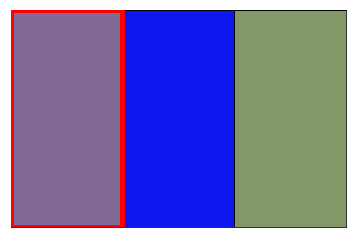

18) Game: synth-0 Round: 19
yellow


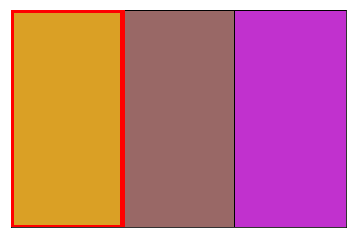

19) Game: synth-0 Round: 20
grey


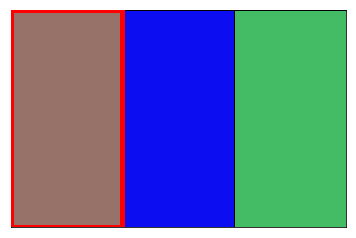

20) Game: synth-0 Round: 21
green


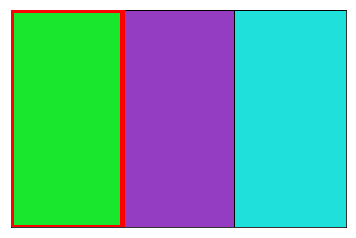

21) Game: synth-0 Round: 22
the bluer grey


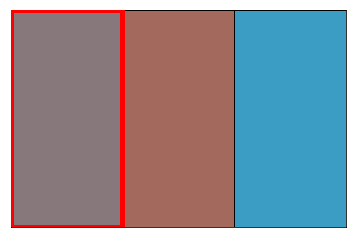

22) Game: synth-0 Round: 23
the pinker pink


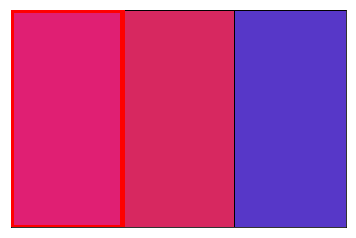

23) Game: synth-0 Round: 24
red


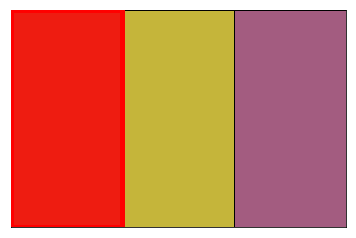

24) Game: synth-0 Round: 25
the duller aqua


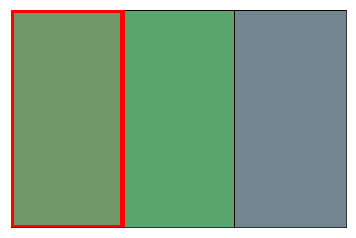

25) Game: synth-0 Round: 26
green


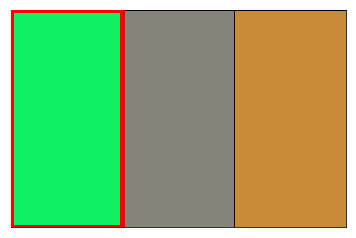

26) Game: synth-0 Round: 27
blue


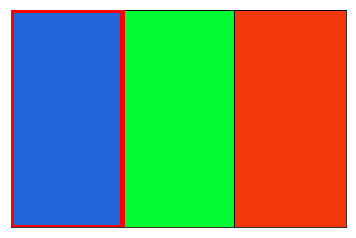

27) Game: synth-0 Round: 28
the most intense blue


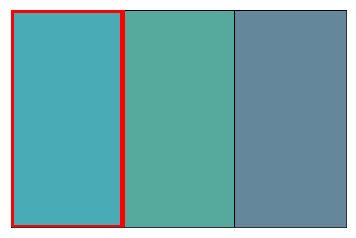

28) Game: synth-0 Round: 29
yellow


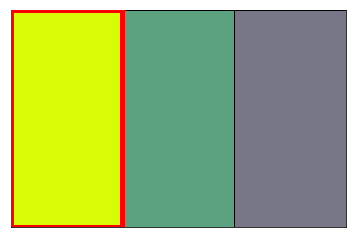

29) Game: synth-0 Round: 30
orange


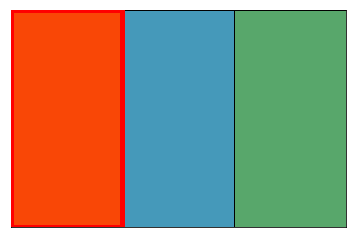

30) Game: synth-0 Round: 31
green


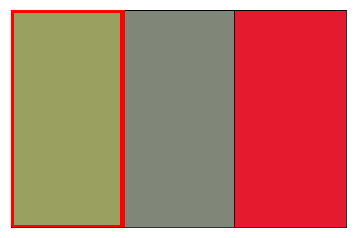

31) Game: synth-0 Round: 32
the lighter blue


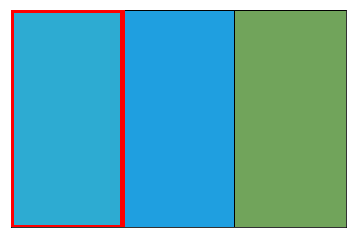

32) Game: synth-0 Round: 33
the dull slightly bluish lavender


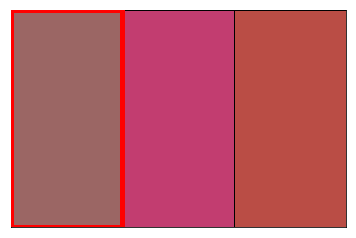

33) Game: synth-0 Round: 34
the brightest one


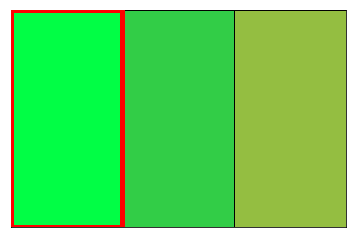

34) Game: synth-0 Round: 35
the one that looks more yellow, but not greyed out


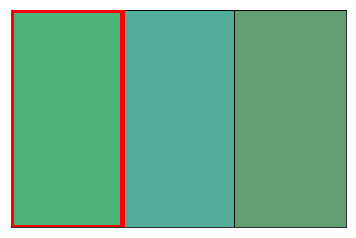

35) Game: synth-0 Round: 36
blue


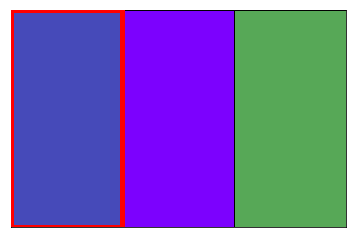

36) Game: synth-0 Round: 37
the most intense one


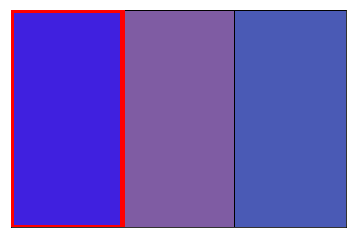

37) Game: synth-0 Round: 38
green


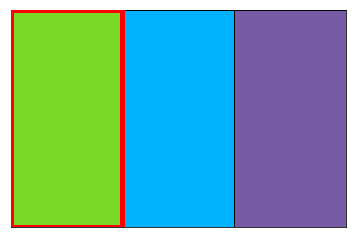

38) Game: synth-0 Round: 39
Royal of the two ~ non the confederate uniform ~ oh darker! more like 'rain'


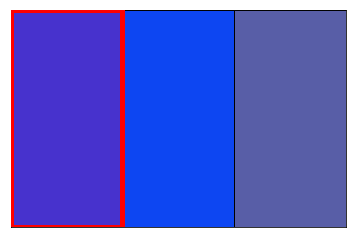

39) Game: synth-0 Round: 40
lavender ~ the duller one


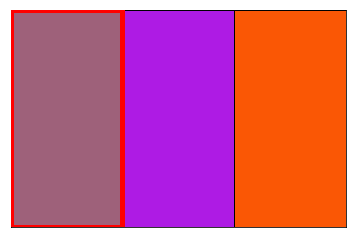

40) Game: synth-0 Round: 41
gray


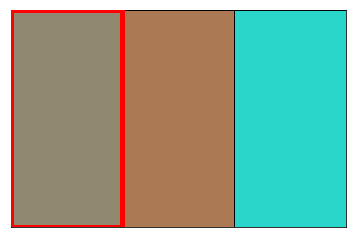

41) Game: synth-0 Round: 42
dull lavender


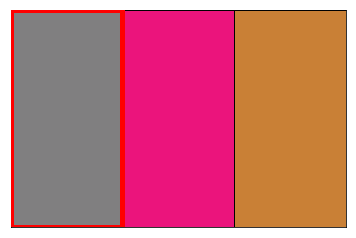

42) Game: synth-0 Round: 43
the yellower green


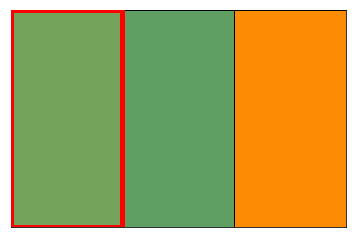

43) Game: synth-0 Round: 44
the most bright and neon looking


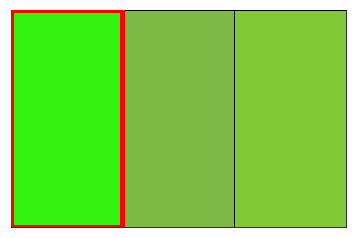

44) Game: synth-0 Round: 45
the dull lavender that is more purplish


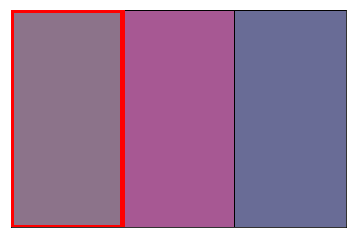

45) Game: synth-0 Round: 46
pink


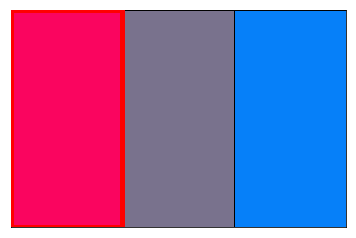

46) Game: synth-0 Round: 47
the brightest one


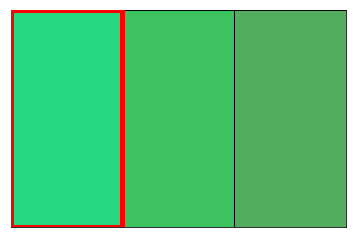

47) Game: synth-0 Round: 48
Concrete ... not with any sky or '....rain'


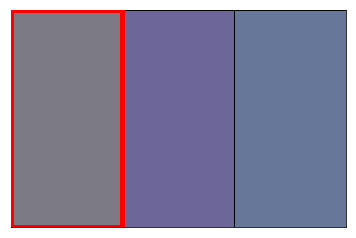

48) Game: synth-0 Round: 49
green


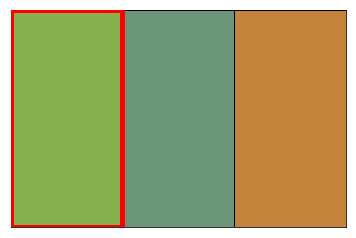

49) Game: synth-0 Round: 50
blue


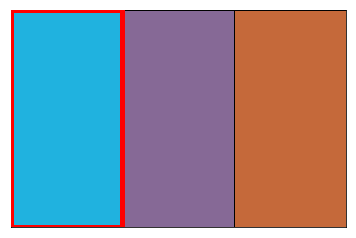

In [467]:
dev_data_synth.display_game_for_gameid("synth-0")

In [593]:
MSELossSum = lambda: nn.MSELoss(reduction='sum') # sorry for this ugliness..... but this is me passing a parameter to the loss func
model = ImaginativeListener(ColorGeneratorWithDistractorsLinear, criterion=MSELossSum, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                color_in_dim=54, color_hidden_dim=100, weight_matrix=torch.tensor(weight_matrix))

In [594]:
train = True
model_file = "../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params"


if train:
    print("Training model and saving to {}:".format(model_file))
    model.fit(train_features, train_targets)
    model.save_model(model_file)
else:
    print("Loading pretrained model")
    model.load_model(model_file)

Training model and saving to ../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params:
---EPOCH 0---
0m 0s (0:0 0.00%) 0.0004
0m 7s (0:1000 6.38%) 0.1877
0m 15s (0:2000 12.77%) 0.1619
0m 24s (0:3000 19.15%) 0.1672
0m 33s (0:4000 25.53%) 0.1628
0m 43s (0:5000 31.92%) 0.1771
0m 53s (0:6000 38.30%) 0.1486
1m 3s (0:7000 44.69%) 0.1398
1m 14s (0:8000 51.07%) 0.1590
1m 25s (0:9000 57.45%) 0.1398
1m 36s (0:10000 63.84%) 0.1474
1m 47s (0:11000 70.22%) 0.1469
1m 58s (0:12000 76.60%) 0.1396
2m 10s (0:13000 82.99%) 0.1410
2m 22s (0:14000 89.37%) 0.1442
2m 33s (0:15000 95.75%) 0.1515
---EPOCH 1---
2m 41s (1:0 0.00%) 0.0000
2m 52s (1:1000 6.38%) 0.1431
3m 4s (1:2000 12.77%) 0.1476
3m 16s (1:3000 19.15%) 0.1577
3m 28s (1:4000 25.53%) 0.1548
3m 41s (1:5000 31.92%) 0.1675
3m 54s (1:6000 38.30%) 0.1459
4m 6s (1:7000 44.69%) 0.1384
4m 18s (1:8000 51.07%) 0.1523
4m 31s (1:9000 57.45%) 0.1358
4m 44s (1:10000 63.84%) 0.1423
4m 56s (1:11000 70.22%) 0.1410
5m 8s (1:12000 76.60%) 0.14

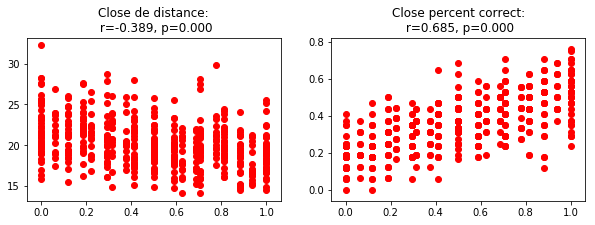

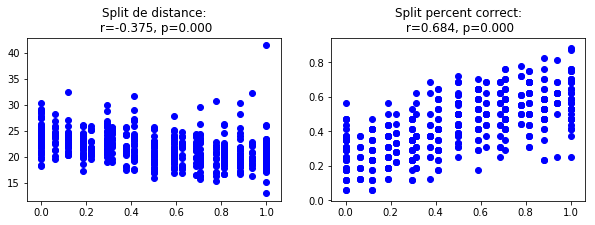

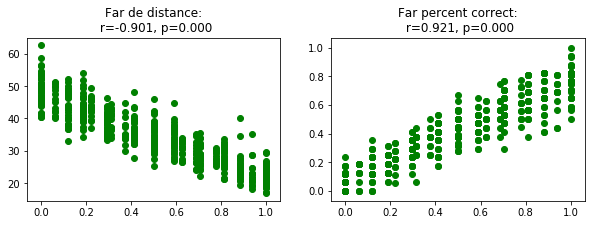

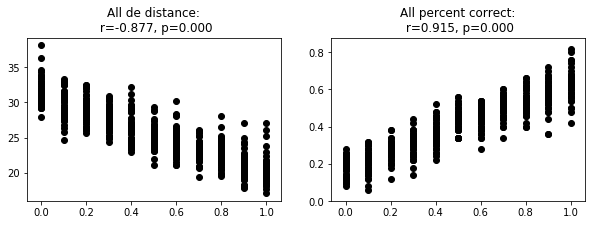

In [581]:
all_scores_eval, model_outputs = assess_model(model)

In [592]:
dev_data_synth.data.head().T

,0,1,2,3,4
gameid,synth-0,synth-0,synth-0,synth-0,synth-0
clkTime,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12
roundNum,1,2,3,4,5
condition,close,split,far,close,split
clickStatus,target,target,target,target,target
clickColH,200,189,352,316,172
clickColS,13,18,65,43,60
clickColL,50,50,50,50,50
clickLocS,3,1,1,1,1
clickLocL,2,3,2,1,1


In [590]:
dev_data_synth.entries[0].condition

'close'

0) Game: synth-0 Round: 1
concrete


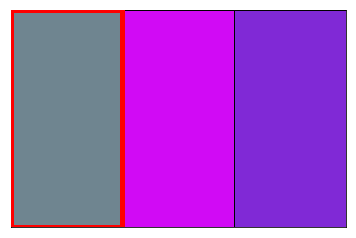

Correct: False, condition: close


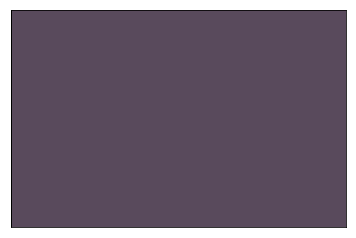

1) Game: synth-0 Round: 2
the concrete mixed with sky


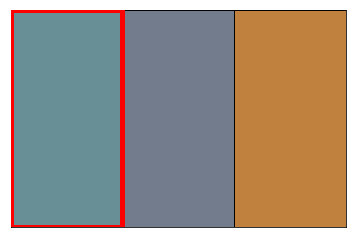

Correct: False, condition: split


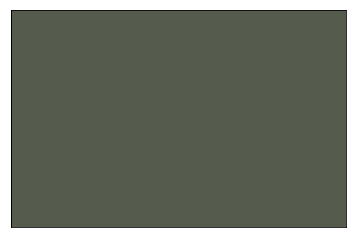

2) Game: synth-0 Round: 3
pink


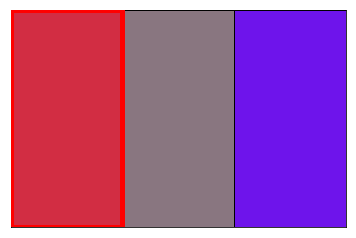

Correct: True, condition: far


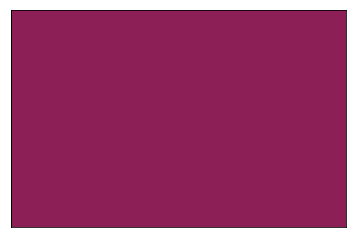

3) Game: synth-0 Round: 4
the dullest purple


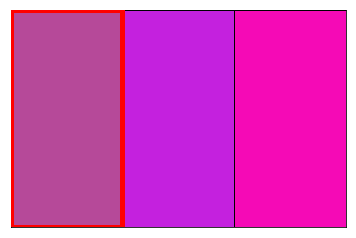

Correct: False, condition: close


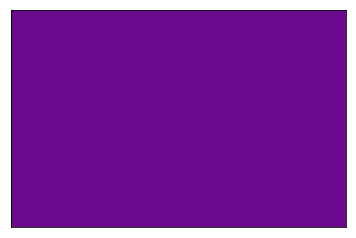

4) Game: synth-0 Round: 5
the brighter blue


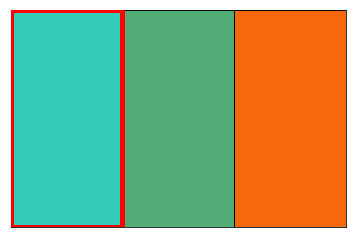

Correct: True, condition: split


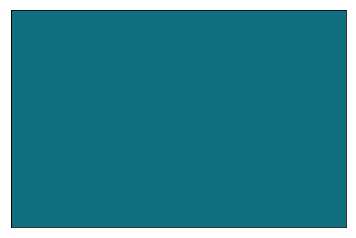

5) Game: synth-0 Round: 6
brown/orange


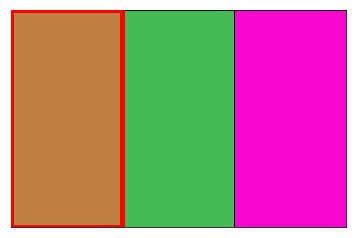

Correct: True, condition: far


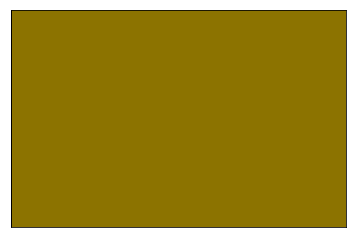

6) Game: synth-0 Round: 7
the yellowest one


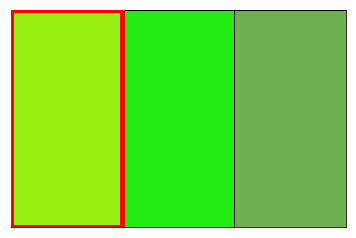

Correct: False, condition: close


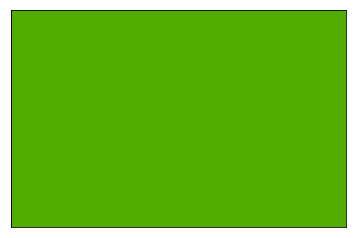

7) Game: synth-0 Round: 8
the greyest one


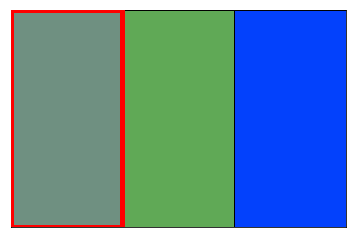

Correct: True, condition: split


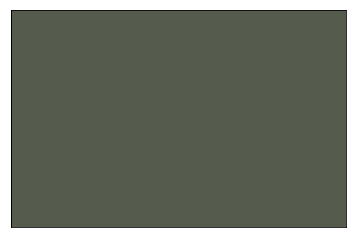

8) Game: synth-0 Round: 9
the brighter lavender


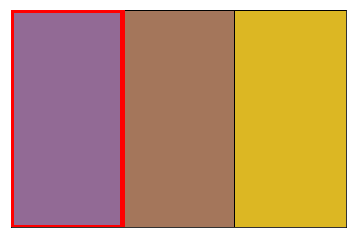

Correct: False, condition: far


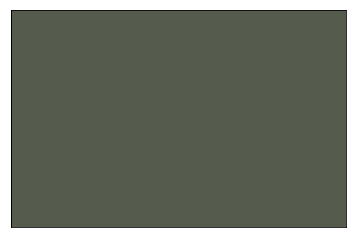

9) Game: synth-0 Round: 10
the most sky of the colors


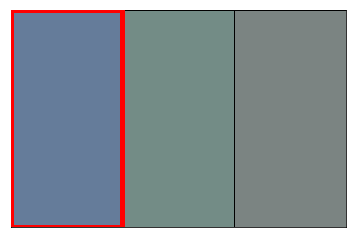

Correct: False, condition: close


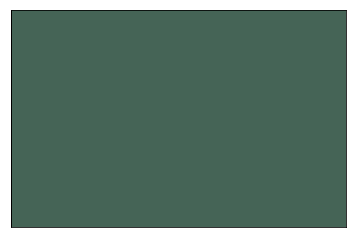

10) Game: synth-0 Round: 11
blue


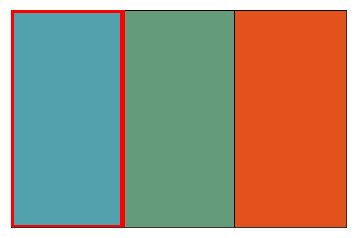

Correct: True, condition: split


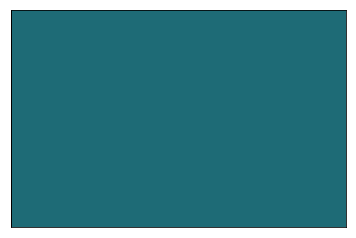

11) Game: synth-0 Round: 12
the purplish blue


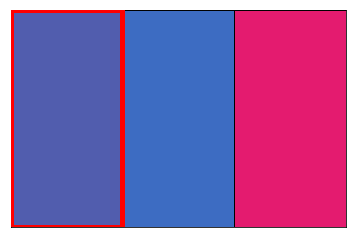

Correct: True, condition: split


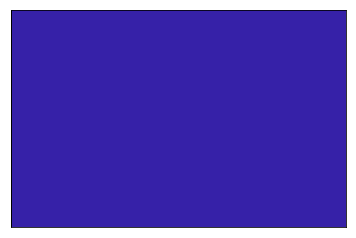

12) Game: synth-0 Round: 13
the most intense one


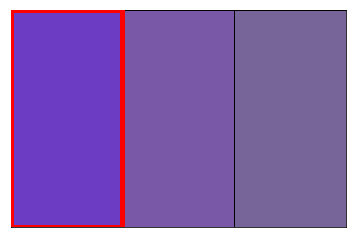

Correct: False, condition: close


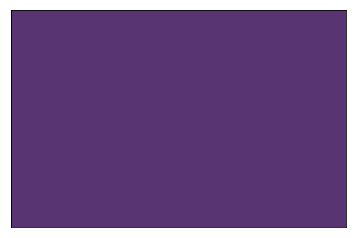

13) Game: synth-0 Round: 14
red


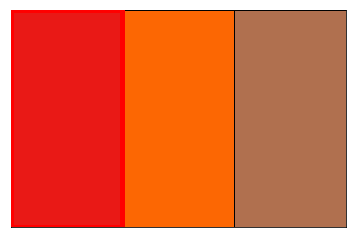

Correct: True, condition: close


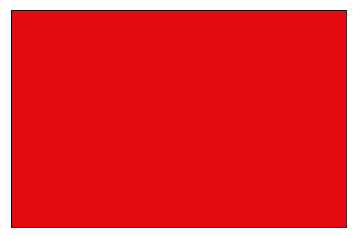

14) Game: synth-0 Round: 15
the more grey green


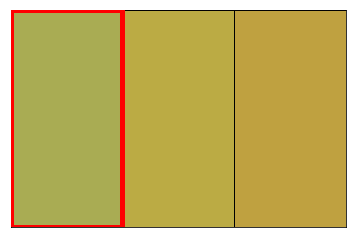

Correct: True, condition: close


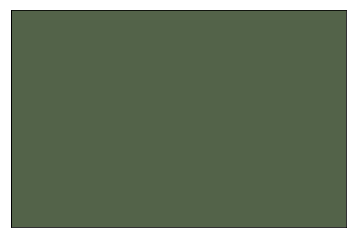

15) Game: synth-0 Round: 16
the greyish blue


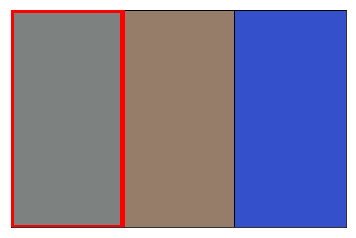

Correct: True, condition: split


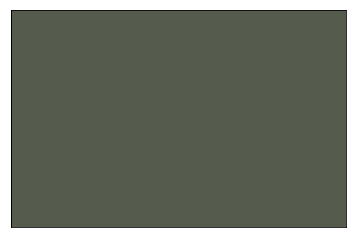

16) Game: synth-0 Round: 17
bright blue green ~ the lighter one


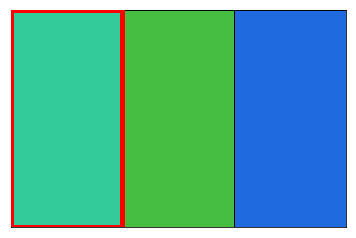

Correct: True, condition: split


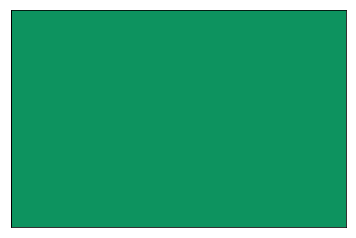

17) Game: synth-0 Round: 18
lavender


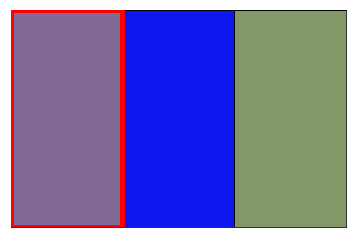

Correct: True, condition: far


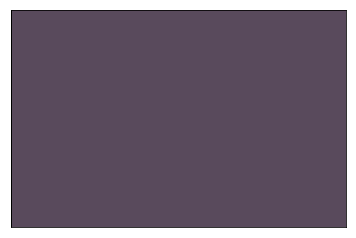

18) Game: synth-0 Round: 19
yellow


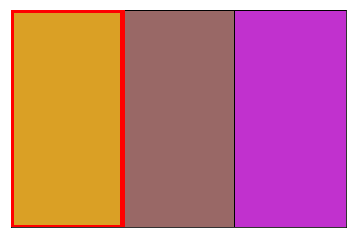

Correct: True, condition: far


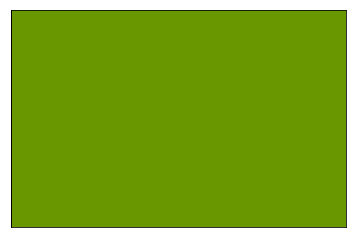

19) Game: synth-0 Round: 20
grey


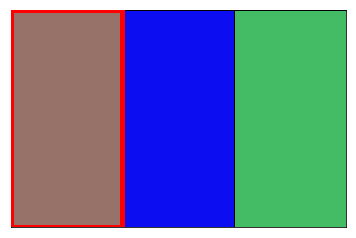

Correct: True, condition: far


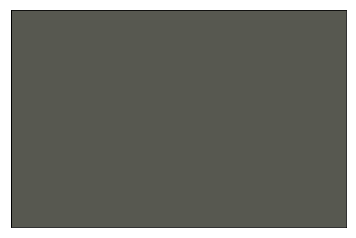

20) Game: synth-0 Round: 21
green


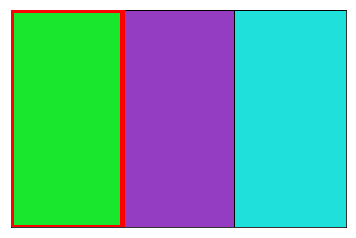

Correct: True, condition: far


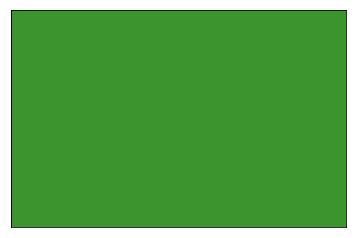

21) Game: synth-0 Round: 22
the bluer grey


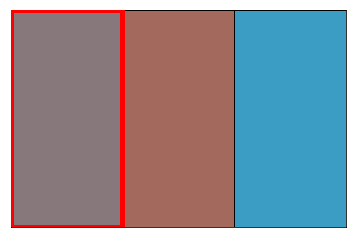

Correct: True, condition: split


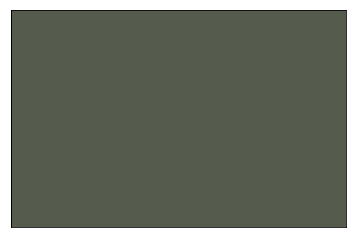

22) Game: synth-0 Round: 23
the pinker pink


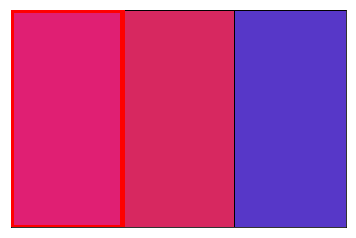

Correct: False, condition: split


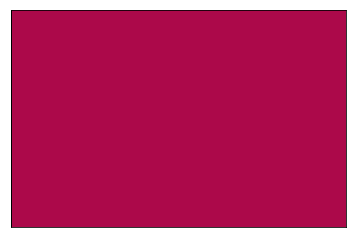

23) Game: synth-0 Round: 24
red


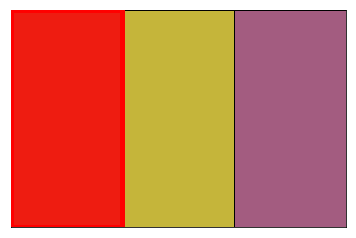

Correct: True, condition: far


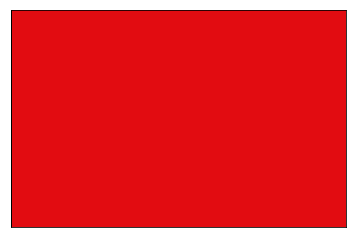

24) Game: synth-0 Round: 25
the duller aqua


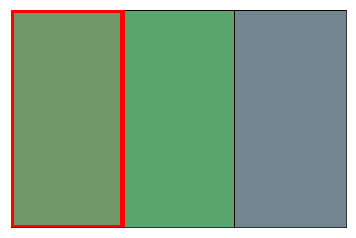

Correct: False, condition: split


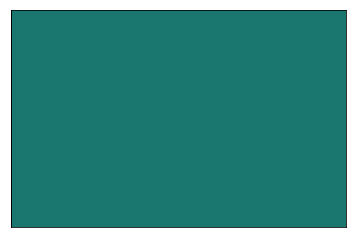

25) Game: synth-0 Round: 26
green


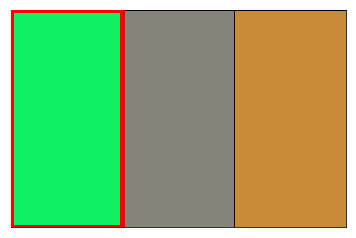

Correct: True, condition: far


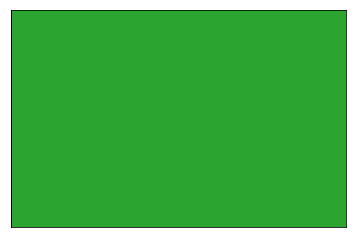

26) Game: synth-0 Round: 27
blue


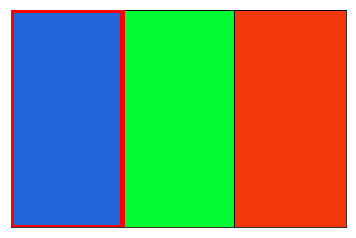

Correct: True, condition: far


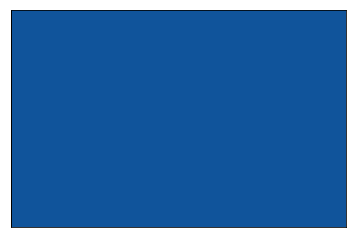

27) Game: synth-0 Round: 28
the most intense blue


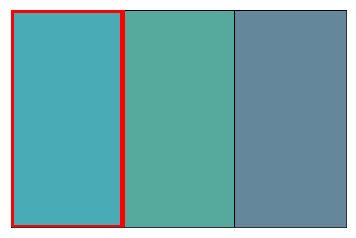

Correct: False, condition: close


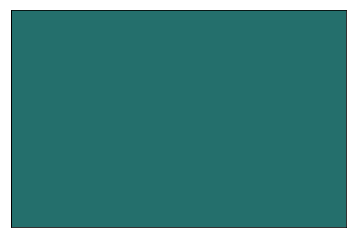

28) Game: synth-0 Round: 29
yellow


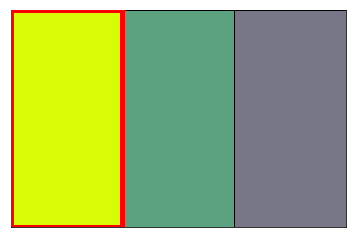

Correct: False, condition: far


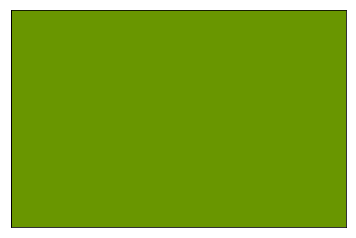

29) Game: synth-0 Round: 30
orange


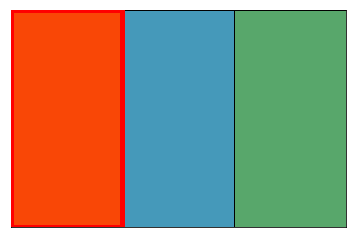

Correct: True, condition: far


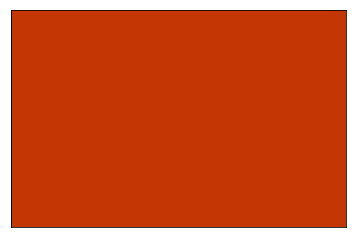

30) Game: synth-0 Round: 31
green


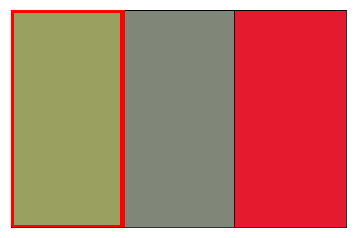

Correct: True, condition: split


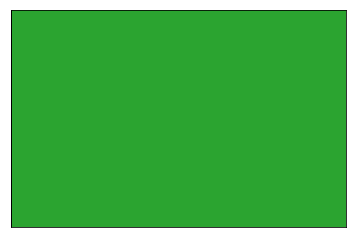

31) Game: synth-0 Round: 32
the lighter blue


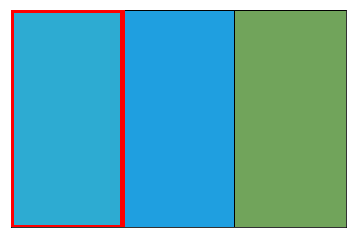

Correct: False, condition: split


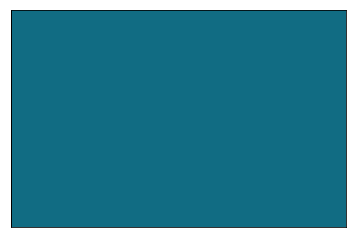

32) Game: synth-0 Round: 33
the dull slightly bluish lavender


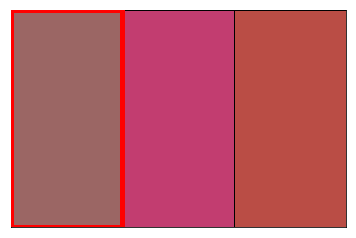

Correct: True, condition: close


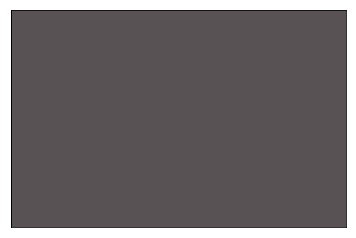

33) Game: synth-0 Round: 34
the brightest one


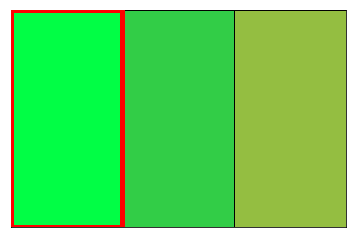

Correct: False, condition: close


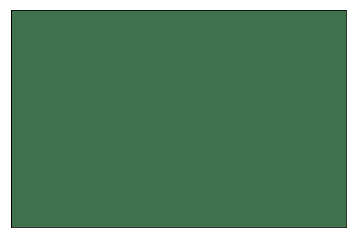

34) Game: synth-0 Round: 35
the one that looks more yellow, but not greyed out


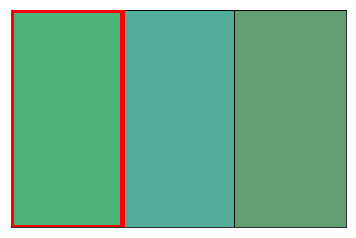

Correct: False, condition: close


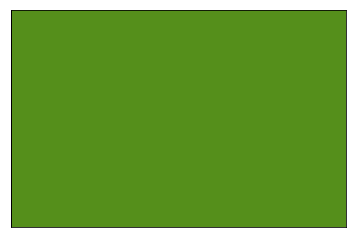

35) Game: synth-0 Round: 36
blue


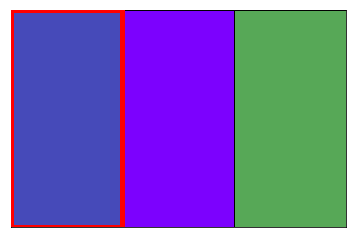

Correct: True, condition: split


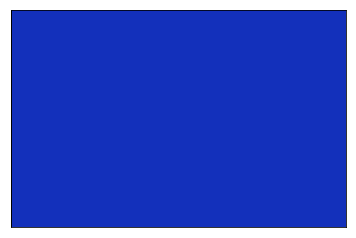

36) Game: synth-0 Round: 37
the most intense one


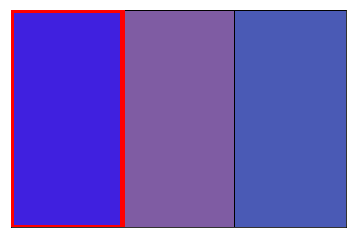

Correct: False, condition: close


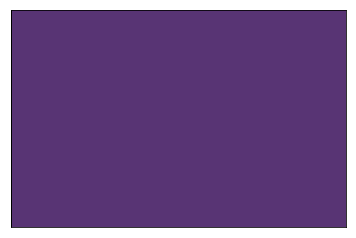

37) Game: synth-0 Round: 38
green


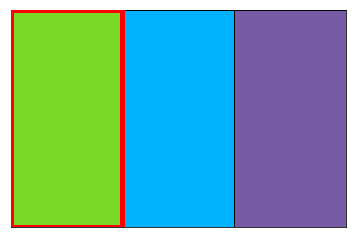

Correct: True, condition: far


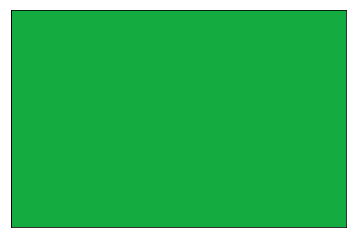

38) Game: synth-0 Round: 39
Royal of the two ~ non the confederate uniform ~ oh darker! more like 'rain'


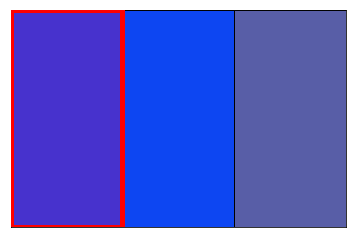

Correct: True, condition: close


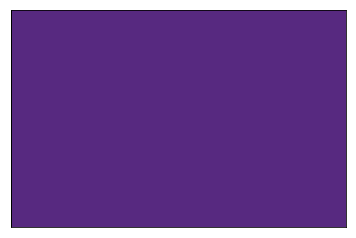

39) Game: synth-0 Round: 40
lavender ~ the duller one


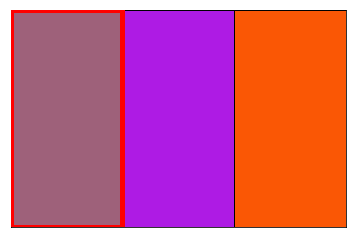

Correct: False, condition: far


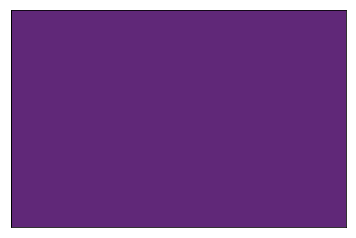

40) Game: synth-0 Round: 41
gray


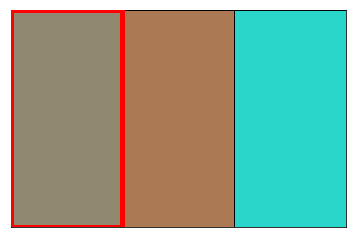

Correct: True, condition: split


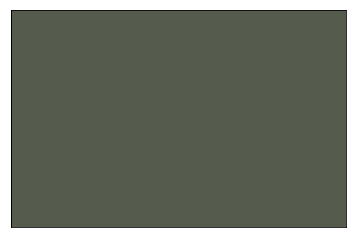

41) Game: synth-0 Round: 42
dull lavender


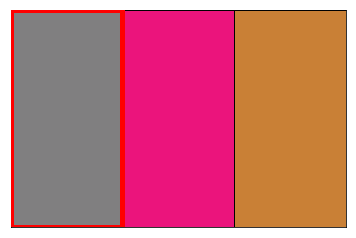

Correct: True, condition: far


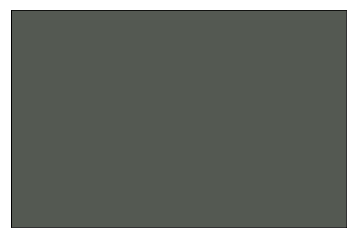

42) Game: synth-0 Round: 43
the yellower green


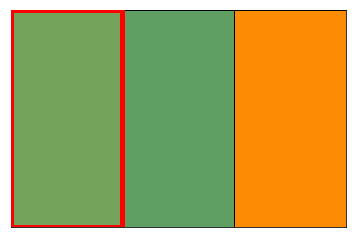

Correct: True, condition: split


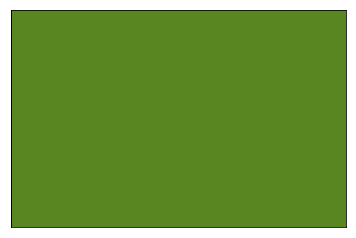

43) Game: synth-0 Round: 44
the most bright and neon looking


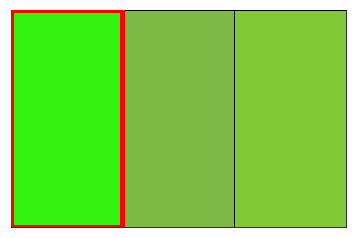

Correct: False, condition: close


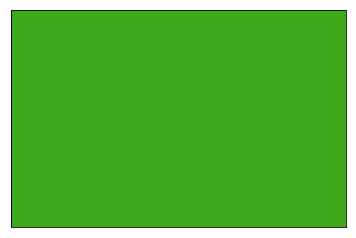

44) Game: synth-0 Round: 45
the dull lavender that is more purplish


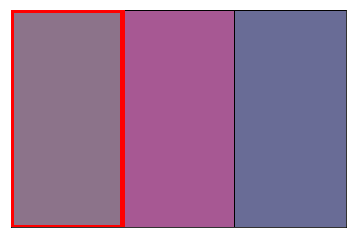

Correct: False, condition: close


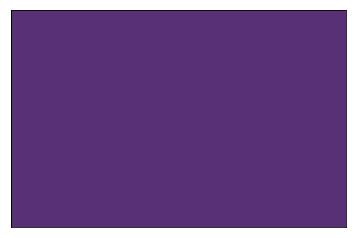

45) Game: synth-0 Round: 46
pink


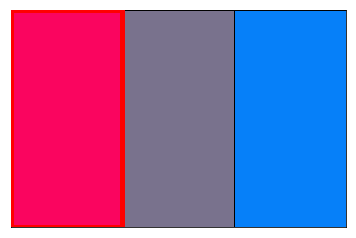

Correct: True, condition: far


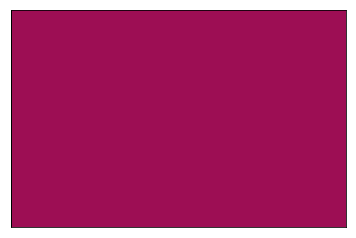

46) Game: synth-0 Round: 47
the brightest one


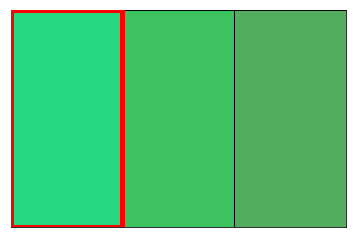

Correct: False, condition: close


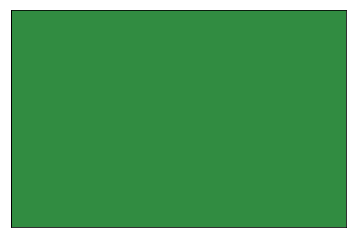

47) Game: synth-0 Round: 48
Concrete ... not with any sky or '....rain'


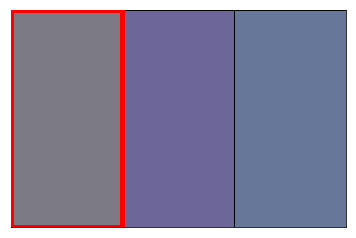

Correct: True, condition: close


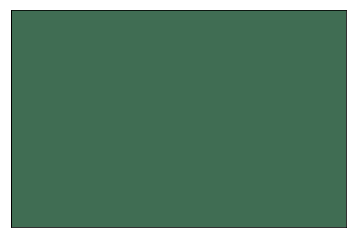

48) Game: synth-0 Round: 49
green


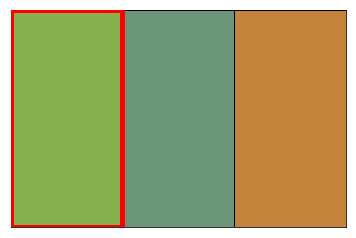

Correct: True, condition: split


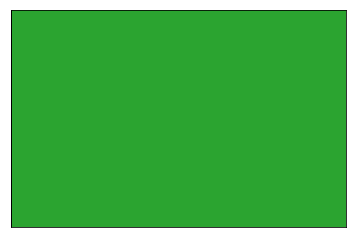

49) Game: synth-0 Round: 50
blue


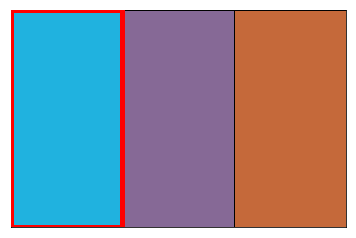

Correct: False, condition: far


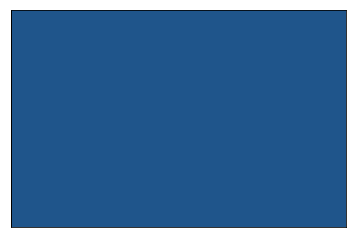

In [589]:
for i, correct, condition, color in zip(range(50), all_scores_eval.model_scores[:50], all_scores_eval.condition[:50], model_outputs[:50]):
    #print("Correct: {}, condition: {}")
    dev_data_synth.display_game(i)
    train_data.display_target(color, "Correct: {}, condition: {}".format(correct, condition))
    

In [497]:
# Let's see how we do at different conditions:
relevant_columns = ["gameid", "roundNum", "numOutcome", "condition"]
eval_df = dev_data_synth.data[relevant_columns].copy()

#

In [498]:
assess_model_outputs = model.predict(assess_features)
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
eval_df["model_scores_dlg"] = assess_model_scores

In [503]:
assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
eval_df["model_scores_dlg_eval"] = assess_model_scores_eval


In [504]:
eval_scores_split = eval_df.groupby(['gameid', 'condition']).mean()

In [500]:
colors = []
for cond in eval_scores_split.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

In [501]:
colors[:10]

['red', 'green', 'blue', 'red', 'green', 'blue', 'red', 'green', 'blue', 'red']

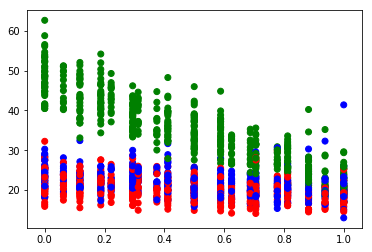

In [502]:
plt.scatter(eval_scores_split['numOutcome'], eval_scores_split['model_scores_dlg'], c=colors)
plt.show()

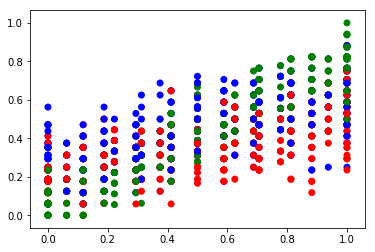

In [505]:
plt.scatter(eval_scores_split['numOutcome'], eval_scores_split['model_scores_dlg_eval'], c=colors)
plt.show()

In [506]:
close_scores = eval_df[eval_df['condition'] == 'close'].groupby('gameid').mean()
split_scores = eval_df[eval_df['condition'] == 'split'].groupby('gameid').mean()
far_scores = eval_df[eval_df['condition'] == 'far'].groupby('gameid').mean()

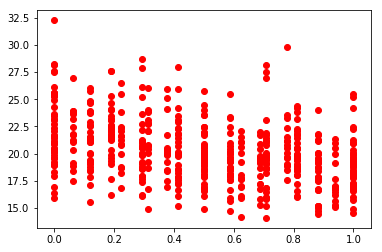

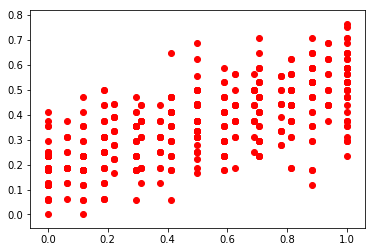

In [508]:
plt.scatter(close_scores['numOutcome'], close_scores['model_scores_dlg'], c="red")
plt.show()
plt.scatter(close_scores['numOutcome'], close_scores['model_scores_dlg_eval'], c="red")
plt.show()


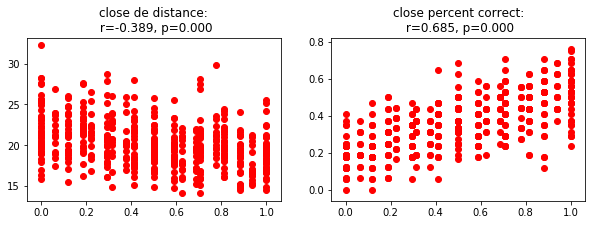

In [532]:
close_de_r = stats.pearsonr(close_scores['numOutcome'], close_scores['model_scores_dlg']) # delta e distance
close_pc_r = stats.pearsonr(close_scores['numOutcome'], close_scores['model_scores_dlg_eval']) # percent correct (closest color is target)

f = plt.figure(figsize=(10, 3))
ax1 = f.add_subplot(121)
ax1.scatter(close_scores['numOutcome'], close_scores['model_scores_dlg'], c="red")
ax1.set_title("{} de distance:\n r={:.3f}, p={:.3f}".format("close", *close_de_r))
ax2 = f.add_subplot(122)
ax2.scatter(close_scores['numOutcome'], close_scores['model_scores_dlg_eval'], c="red")
ax2.set_title("{} percent correct:\n r={:.3f}, p={:.3f}".format("close", *close_pc_r))
plt.show()

In [568]:
def find_correlation(scores_df, color, name):
    close_de_r = stats.pearsonr(scores_df['numOutcome'], scores_df['model_scores']) # delta e distance
    close_pc_r = stats.pearsonr(scores_df['numOutcome'], scores_df['model_scores_eval']) # percent correct (closest color is target)

    f = plt.figure(figsize=(10, 3))
    ax1 = f.add_subplot(121)
    ax1.scatter(scores_df['numOutcome'], scores_df['model_scores'], c=color)
    ax1.set_title("{} de distance:\n r={:.3f}, p={:.3f}".format(name, *close_de_r))
    ax2 = f.add_subplot(122)
    ax2.scatter(scores_df['numOutcome'], scores_df['model_scores_eval'], c=color)
    ax2.set_title("{} percent correct:\n r={:.3f}, p={:.3f}".format(name, *close_pc_r))
    plt.show()  

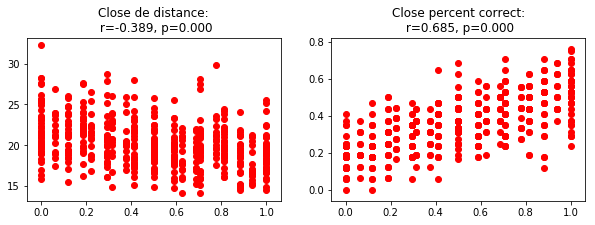

In [534]:
find_correlation(close_scores, "red", "Close")

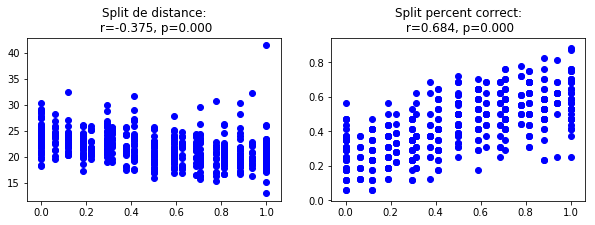

In [535]:
find_correlation(split_scores, "blue", "Split")

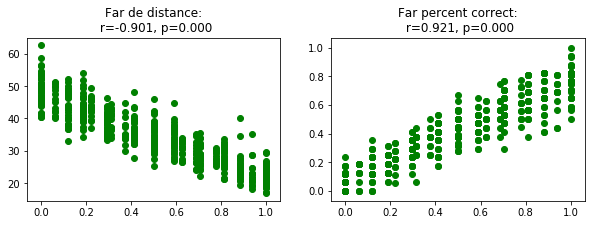

In [537]:
find_correlation(far_scores, "green", "Far")

In [509]:
stats.pearsonr(close_scores['numOutcome'], close_scores['model_scores_dlg_eval'])

(0.6850094882516145, 7.428281319615343e-73)

In [510]:
stats.pearsonr(close_scores['numOutcome'], close_scores['model_scores_dlg'])

(-0.3885624912253377, 4.4465223979528066e-20)

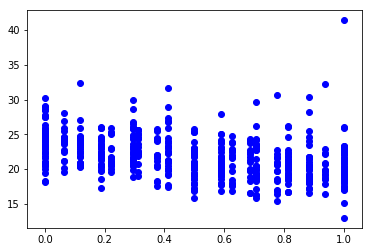

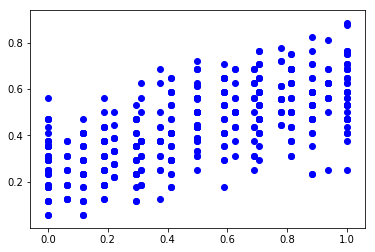

In [514]:
plt.scatter(split_scores['numOutcome'], split_scores['model_scores_dlg'], c="blue")
plt.show()
plt.scatter(split_scores['numOutcome'], split_scores['model_scores_dlg_eval'], c="blue")
plt.show()


In [512]:
stats.pearsonr(split_scores['numOutcome'], split_scores['model_scores_dlg_eval'])

(0.6836307915530794, 1.8562085167310427e-72)

In [513]:
stats.pearsonr(split_scores['numOutcome'], split_scores['model_scores_dlg'])

(-0.3747214279504781, 1.1126074990026725e-18)

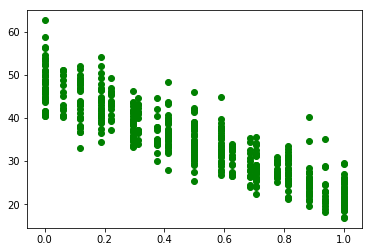

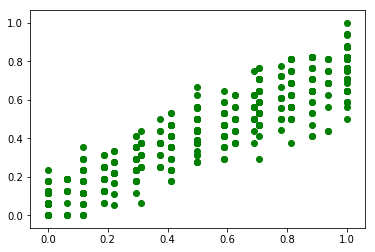

In [515]:
plt.scatter(far_scores['numOutcome'], far_scores['model_scores_dlg'], c="green")
plt.show()
plt.scatter(far_scores['numOutcome'], far_scores['model_scores_dlg_eval'], c="green")
plt.show()


In [516]:
stats.pearsonr(far_scores['numOutcome'], far_scores['model_scores_dlg_eval'])

(0.9206480488834453, 1.6049863636952038e-212)

In [517]:
stats.pearsonr(far_scores['numOutcome'], far_scores['model_scores_dlg'])

(-0.9007506566999681, 1.1792873482506725e-188)

In [575]:
eval_df

,gameid,roundNum,numOutcome,condition,model_scores_dlg,model_scores_dlg_eval
0,synth-0,1,1,close,27.567243,False
1,synth-0,2,1,split,23.137266,False
2,synth-0,3,1,far,20.500035,True
3,synth-0,4,1,close,20.742831,False
4,synth-0,5,1,split,32.049066,True
5,synth-0,6,1,far,16.470218,True
6,synth-0,7,1,close,17.211951,False
7,synth-0,8,1,split,20.672108,True
8,synth-0,9,1,far,35.410361,False
9,synth-0,10,1,close,24.058365,False


In [573]:
close_scores['model_scores_dlg_eval']

gameid
synth-0      0.294118
synth-1      0.312500
synth-10     0.500000
synth-100    0.500000
synth-101    0.375000
synth-102    0.437500
synth-103    0.444444
synth-104    0.562500
synth-105    0.437500
synth-106    0.333333
synth-107    0.437500
synth-108    0.500000
synth-109    0.555556
synth-11     0.647059
synth-110    0.187500
synth-111    0.375000
synth-112    0.555556
synth-113    0.437500
synth-114    0.500000
synth-115    0.333333
synth-116    0.312500
synth-117    0.500000
synth-118    0.444444
synth-119    0.375000
synth-12     0.588235
synth-120    0.312500
synth-121    0.333333
synth-122    0.562500
synth-123    0.562500
synth-124    0.444444
               ...   
synth-72     0.437500
synth-73     0.352941
synth-74     0.529412
synth-75     0.437500
synth-76     0.588235
synth-77     0.352941
synth-78     0.437500
synth-79     0.176471
synth-8      0.529412
synth-80     0.470588
synth-81     0.437500
synth-82     0.529412
synth-83     0.411765
synth-84     0.625000
syn

In [490]:
torch.tensor([[[1, 2, 3], [1, 4, 5]]]).reshape(1, 1, -1)

tensor([[[1, 2, 3, 1, 4, 5]]])

In [431]:
my_loss()(torch.tensor([[2., 3., 4.]]), torch.tensor([[1., 2., 3.]]))

tensor(3.)

In [429]:
my_loss()(torch.tensor([[0.0938, 0.2852, 0.9062]]), torch.tensor([[0.03, 0.2852, 0.9062]]))

tensor(0.0041)

In [426]:
my_loss = lambda: nn.MSELoss(reduction='sum')

In [428]:
my_loss()

MSELoss()

In [355]:
l, a, b = c.view(-1, 1)[:3]

In [356]:
print(l, a, b)

tensor([0.3249], grad_fn=<SelectBackward>) tensor([0.3353], grad_fn=<SelectBackward>) tensor([0.3397], grad_fn=<SelectBackward>)


In [361]:
torch.sqrt(a**2 + b**2)

tensor([0.4774], grad_fn=<SqrtBackward>)

In [365]:
c

tensor([[0.3249, 0.3353, 0.3397]], grad_fn=<SoftmaxBackward>)

In [366]:
c>0.33

tensor([[0, 1, 1]], dtype=torch.uint8)

In [367]:
c.copy()

AttributeError: 'Tensor' object has no attribute 'copy'

In [357]:
c.detach().numpy().shape

(1, 3)

In [359]:
ln, an, bn = np.rollaxis(c.detach().numpy(), -1)[:3]

In [360]:
np.hypot(an, bn)

array([0.47735938], dtype=float32)

In [314]:
# THIS DOESN'T WORK BC IT'S NOT DIFFERENTIABLE
# THIS IS SHAMELESSLY COPIED FROM 
# https://github.com/scikit-image/scikit-image/blob/7fd217c78c996a4494e09dd1b52bd617f3c9800b/skimage/color/delta_e.py#L122
# with all of the np's substituted with torch differentiable operations

def deltaE_ciede2000_torch(lab1, lab2, kL=1, kC=1, kH=1)
    """Color difference as given by the CIEDE 2000 standard.
    CIEDE 2000 is a major revision of CIDE94.  The perceptual calibration is
    largely based on experience with automotive paint on smooth surfaces.
    Parameters
    ----------
    lab1 : array_like [torch tensor]
        reference color (Lab colorspace)
    lab2 : array_like [torch tensor]
        comparison color (Lab colorspace)
    kL : float (range), optional
        lightness scale factor, 1 for "acceptably close"; 2 for "imperceptible"
        see deltaE_cmc
    kC : float (range), optional
        chroma scale factor, usually 1
    kH : float (range), optional
        hue scale factor, usually 1
    Returns
    -------
    deltaE : array_like
        The distance between `lab1` and `lab2`
    Notes
    -----
    CIEDE 2000 assumes parametric weighting factors for the lightness, chroma,
    and hue (`kL`, `kC`, `kH` respectively).  These default to 1.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Color_difference
    .. [2] http://www.ece.rochester.edu/~gsharma/ciede2000/ciede2000noteCRNA.pdf
           :DOI:`10.1364/AO.33.008069`
    .. [3] M. Melgosa, J. Quesada, and E. Hita, "Uniformity of some recent
           color metrics tested with an accurate color-difference tolerance
           dataset," Appl. Opt. 33, 8069-8077 (1994).
    """
    unroll = False
    if lab1.dim() == 1 and lab2.dim() == 1:
        unroll = True
        if lab1.dim() == 1:
            lab1 = lab1[None, :]
        if lab2.dim() == 1:
            lab2 = lab2[None, :]
    L1, a1, b1 = lab1.view(-1, 1)[:3] # np.rollaxis(lab1, -1)[:3]
    L2, a2, b2 = lab2.view(-1, 1)[:3] # np.rollaxis(lab2, -1)[:3]

    # distort `a` based on average chroma
    # then convert to lch coordines from distorted `a`
    # all subsequence calculations are in the new coordiantes
    # (often denoted "prime" in the literature)
    Cbar = 0.5 * (torch.sqrt(a1**2 + b1**2) + torch.sqrt(a2**2 + b2**2))
    c7 = Cbar ** 7
    G = 0.5 * (1 - torch.sqrt(c7 / (c7 + 25 ** 7)))
    scale = 1 + G
    C1, h1 = _cart2polar_2pi(a1 * scale, b1) # make this work
    C2, h2 = _cart2polar_2pi(a2 * scale, b2)
    # recall that c, h are polar coordiantes.  c==r, h==theta

    # cide2000 has four terms to delta_e:
    # 1) Luminance term
    # 2) Hue term
    # 3) Chroma term
    # 4) hue Rotation term

    # lightness term
    Lbar = 0.5 * (L1 + L2)
    tmp = (Lbar - 50) ** 2
    SL = 1 + 0.015 * tmp / torch.sqrt(20 + tmp)
    L_term = (L2 - L1) / (kL * SL)

    # chroma term
    Cbar = 0.5 * (C1 + C2)  # new coordiantes
    SC = 1 + 0.045 * Cbar
    C_term = (C2 - C1) / (kC * SC)

    # hue term
    h_diff = h2 - h1
    h_sum = h1 + h2
    CC = C1 * C2

    dH = h_diff.copy()
    dH[h_diff > np.pi] -= 2 * np.pi
    dH[h_diff < -np.pi] += 2 * np.pi
    dH[CC == 0.] = 0.  # if r == 0, dtheta == 0
    dH_term = 2 * torch.sqrt(CC) * torch.sin(dH / 2)

    Hbar = h_sum.copy()
    mask = np.logical_and(CC != 0., np.abs(h_diff) > np.pi)
    Hbar[mask * (h_sum < 2 * np.pi)] += 2 * np.pi
    Hbar[mask * (h_sum >= 2 * np.pi)] -= 2 * np.pi
    Hbar[CC == 0.] *= 2
    Hbar *= 0.5

    T = (1 -
         0.17 * torch.cos(Hbar - np.deg2rad(30)) +
         0.24 * torch.cos(2 * Hbar) +
         0.32 * torch.cos(3 * Hbar + np.deg2rad(6)) -
         0.20 * torch.cos(4 * Hbar - np.deg2rad(63))
         )
    SH = 1 + 0.015 * Cbar * T

    H_term = dH_term / (kH * SH)

    # hue rotation
    c7 = Cbar ** 7
    Rc = 2 * np.sqrt(c7 / (c7 + 25 ** 7))
    dtheta = np.deg2rad(30) * np.exp(-((np.rad2deg(Hbar) - 275) / 25) ** 2)
    R_term = -np.sin(2 * dtheta) * Rc * C_term * H_term

    # put it all together
    dE2 = L_term ** 2
    dE2 += C_term ** 2
    dE2 += H_term ** 2
    dE2 += R_term
    ans = np.sqrt(dE2)
    if unroll:
        ans = ans[0]
    return ans
class CIEDE2000Loss(nn.Module):
    
    def __init__(self):
        super(CIEDE2000Loss, self).__init__()
        
    def forward(self, output, target, ):
        # Will uses CIEDE2000 image distance
        

In [318]:
ciede_loss = CIEDE2000Loss()

In [319]:
ciede_loss(target_test, c)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [326]:
a = torch.tensor(1.5)
a.requires_grad_()
a = 5*a
print(a)
b = torch.round(a)
print(b)
b.backward()

tensor(7.5000, grad_fn=<MulBackward0>)
tensor(8., grad_fn=<RoundBackward>)


In [132]:
cg_test = ColorGenerator(100, 100, feature_handler.caption_featurizer.caption_indexer.size)

In [135]:
cap_test = torch.tensor([train_features[0][0]])

In [354]:
c = cg_test(cap_test)

torch.Size([1, 7, 200])
torch.Size([1, 200])
torch.Size([1, 100])
torch.Size([1, 3])


In [154]:
c = c.type(torch.DoubleTensor)

In [316]:
c

tensor([[0.3249, 0.3353, 0.3397]], dtype=torch.float64,
       grad_fn=<CopyBackwards>)

In [149]:
target_test = torch.tensor([train_targets[0]])

In [150]:
target_test

tensor([[0.0938, 0.2852, 0.9062]], dtype=torch.float64)

In [144]:
test_criterion = torch.nn.CosineEmbeddingLoss()

In [157]:
test_criterion(c, target_test.detach(), torch.tensor(1, dtype=torch.double))

tensor(0.2128, dtype=torch.float64, grad_fn=<MeanBackward1>)

In [163]:
import math
math.acos(0)

1.5707963267948966

In [168]:
import scipy

In [169]:
scipy.spatial.distance.cosine([0.3249, 0.3353, 0.3397], [0.0938, 0.2852, 0.9062])

0.2127393174179225

In [225]:
co1 = np.array([24, 73, 232])/255
co2 = np.array([176, 17, 239])/255

In [226]:
delta_e_dist(np.array(co1), np.array(co2))

18.546314546540913

In [167]:
torch.cos(c, target_test)

TypeError: cos() takes 1 positional argument but 2 were given

In [170]:
1 - np.dot([0.3249, 0.3353, 0.3397], [0.0938, 0.2852, 0.9062])/(np.linalg.norm([0.3249, 0.3353, 0.3397])*np.linalg.norm([0.0938, 0.2852, 0.9062]))

0.21273931741792262

In [219]:
(255*np.array([0.3249, 0.3353, 0.3397])).astype(np.uint8)#, dtype=np.uint8)

array([82, 85, 86], dtype=uint8)

In [222]:
np.round(255*np.array([0.3249, 0.3353, 0.3397]))

array([83., 86., 87.])

In [ ]:
torch.nn.fun

In [121]:
nn.functional.softmax(c, dim=1)

tensor([[0.3346, 0.3370, 0.3284]], grad_fn=<SoftmaxBackward>)

In [86]:
train_data[0].colors[0].rgb_norm

[0.09375, 0.28515625, 0.90625]

In [109]:
train_targets[:3]

array([[0.09375   , 0.28515625, 0.90625   ],
       [0.4140625 , 0.375     , 0.625     ],
       [0.78515625, 0.21484375, 0.77734375]])

In [97]:
x = np.array([[1], [2]])

In [99]:
x.shape[-1]

(2, 1)

In [94]:
x.flatten()

array([1, 1, 2, 3])

In [50]:
# note that this only seems to work with np.uint8 data type (each entry is a character?)
target = color.rgb2lab(np.array([[[24, 73, 232]]], dtype=np.uint8)).flatten()
dist1 = color.rgb2lab(np.array([[[176, 17, 239]]], dtype=np.uint8)).flatten()
dist2 = color.rgb2lab(np.array([[[42, 10, 246]]], dtype=np.uint8)).flatten()


In [51]:
# Will uses CIEDE2000 image distance
color.deltaE_ciede2000(target, dist1)

18.546314546540913

In [52]:
color.deltaE_ciede2000(target, dist2)

10.063183079501849

In [57]:
color.deltaE_ciede2000(dist1, dist2)

16.399197198003755

In [58]:
# note that this only seems to work with np.uint8 data type (each entry is a character?)
target = color.rgb2lab(np.array([[[106, 96, 160]]], dtype=np.uint8)).flatten()
dist1 = color.rgb2lab(np.array([[[44, 212, 69]]], dtype=np.uint8)).flatten()
dist2 = color.rgb2lab(np.array([[[196, 182, 60]]], dtype=np.uint8)).flatten()




In [59]:
color.deltaE_ciede2000(target, dist1)

57.42886064631289

In [60]:
color.deltaE_ciede2000(target, dist2)

61.6206567808671

In [61]:
color.deltaE_ciede2000(dist2, dist1)

24.7554932354882

In [34]:
color.rgb2lab(np.array([[[154, 147, 151]]], dtype=np.uint8))

array([[[61.63005128,  3.32356587, -1.18519659]]])

In [9]:
from skimage import data
from skimage.color import rgb2lab, lab2lch
img = data.astronaut()
img_lab = rgb2lab(img)
img_lch = lab2lch(img_lab)

In [41]:
img

array([[[154, 147, 151],
        [109, 103, 124],
        [ 63,  58, 102],
        ...,
        [127, 120, 115],
        [120, 117, 106],
        [125, 119, 110]],

       [[177, 171, 171],
        [144, 141, 143],
        [113, 114, 124],
        ...,
        [127, 118, 112],
        [124, 115, 108],
        [121, 116, 105]],

       [[201, 194, 193],
        [182, 178, 175],
        [168, 165, 164],
        ...,
        [128, 120, 117],
        [126, 116, 112],
        [124, 114, 109]],

       ...,

       [[186, 170, 176],
        [186, 170, 177],
        [183, 168, 170],
        ...,
        [  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   0]],

       [[183, 169, 170],
        [182, 167, 171],
        [185, 164, 176],
        ...,
        [  0,   0,   1],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[184, 167, 172],
        [183, 165, 169],
        [180, 162, 171],
        ...,
        [  0,   0,   0],
        [  1,   1,   1],
        [  0,   0,   0]]

In [16]:
%matplotlib inline

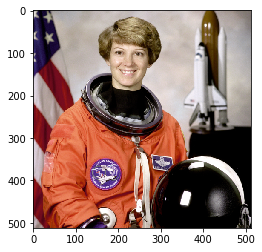

In [20]:
plt.imshow(img)